# Testing `hera_cal` with EoR, Foregrounds, and Time-Varying Gains

Bobby Pascua, Zachary Martinot, and the HERA Validation Team

## Setup and Metadata

### Abstract

We uncalibrate noiseless observations of a sky with a $1/k^2$ EoR power spectrum and foregrounds and compute the power spectrum of visibilities with various levels of calibration applied. We uncalibrate the simulated visibilities by generating gains with `hera_sim.sigchain.gen_gains` and modifying these gains by adding random phase offsets and applying linear modulation in time. We examine the power spectra of five different sets of visibilities:
* Perfectly calibrated visibilities (direct simulation output)
* Uncalibrated visibilities (simulation output with gains applied)
* Simply calibrated visibilities (calibration with frequency-independent amplitudes and delays)
* Unsmoothed, absolutely calibrated visibilities
* Smoothed, absolutely calibrated visibilities

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os
import copy
import glob

import astropy
import astropy.units as units
import h5py

import hera_cal
import hera_pspec
import hera_sim
import pyuvdata
import uvtools

from hera_cal import io, redcal, abscal, smooth_cal, apply_cal
from hera_cal.utils import split_bl
from hera_sim.sigchain import gen_gains
from pyuvdata import UVData, UVBeam
from hera_pspec.data import DATA_PATH as PSPEC_DATA_PATH

/users/rpascua/hera_packages/hera_sim/hera_sim/__init__.py:35: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the Simulator class is the most intuitive way of interfacing with the hera_sim package features.
  FutureWarning)


### Description

Last executed: {{str(datetime.now())}}

- **Major Step Description:** Simulate visibilities of foregrounds (diffuse and point source) and for a $1/k^2$ EoR power spectrum. Apply gains which vary linearly in time, calibrate the resulting data, and extract power spectra.
- **Minor Variation Description:** ?
- **Pipelines Tested:** `redcal`, `abscal`, `smooth_cal`, `pspec`
- **Criteria**:
  1. {Explicit Criterion for success 1}
  2. {Explicit Criterion for success 2}
  

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. {Test results for criteria 1}
2. {Test results for criteria 2...}

{Brief notes on anything else interesting that was noted during testing}

### Software

HERA software used in this validation test, with associate git commit hash:

* ``pyuvdata``: ``{{pyuvdata.version.git_hash}}``
* ``hera_cal``: ``{{hera_cal.version.git_hash}}``
* ``hera_sim``: ``{{hera_sim.version.git_hash}}``
* ``hera_pspec``: ``{{hera_pspec.version.git_hash}}``
* ``uvtools``: ``{{uvtools.version.git_hash}}``

Versions of other software used in this validation test:

* ``numpy``: v{{np.version.version}}
* ``astropy``: v{{astropy.version.version}} ({{astropy.version.githash}})
* ``matplotlib``: v3.1.0

### Data

The following paths reflect the exact locations of all data used in this test:

In [2]:
data_path = "/lustre/aoc/projects/hera/Validation/"
data_prefix = "hera_hex37_100-200MHz_HERA_dipole_"

cal_path = os.path.join(data_path, "test-2.1.0/calibrations/single_file/")
spec_path = os.path.join(data_path, "test-2.1.0/spectra/single_file/")
spec_path_full_day = os.path.join(data_path, "test-2.1.0/spectra/full_day/")
vis_path = os.path.join(data_path, "test-2.1.0/visibilities/single_file/")
plot_path = os.path.join(data_path, "test-2.1.0/plots/")
pipeline_output_path = os.path.join(data_path, "test-2.1.0/original_analysis_data_products/")

eor_path = os.path.join(data_path, 
                        data_prefix+"beam_pow_neg2_pspec/realization_0.uvh5")
gsm_path = os.path.join(data_path, 
                        data_prefix+"eGSM_preview/hera_hex37_egsm_preview.uvh5")
gleam_path = os.path.join(data_path, 
                          data_prefix+"full_gleam_plus_brights_v01/hera_hex37_full_gleam_plus_brights_v01.uvh5")

# Path to beam normalization data
omegas_data_path = '/lustre/aoc/projects/hera/Validation/HERA_dipole_Omegas/HERA_dipole_Omegas.h5'
assert os.path.exists(omegas_data_path)


for path in (eor_path, gsm_path, gleam_path):
    assert os.path.exists(path)

## Extra Utility Functions

In [3]:
# function for saving figures
def save_fig(fig, save_path):
    if isinstance(save_path, (list, tuple)):
        for path in save_path:
            fig.savefig(path)
    else:
        fig.savefig(save_path)

In [4]:
# wrapper for uvtools.plot.waterfall
def plot_gain_waterfalls(gain_dict, extent, bounds, modes, save_path=None, time_units="s"):
    fig = plt.figure(figsize=(14,8))
    axes = fig.subplots(2,3)
    for j, ax in enumerate(axes.ravel()):
        gain_type = list(gain_dict.keys())[j % 3]
        plot_type = ("Amplitude", "Phase")[j // 3]
        mode = modes[j // 3]
        
        mx = bounds[j // 3][1]
        drng = None if mx is None else bounds[j // 3][1] - bounds[j // 3][0]
        
        ax.set_xlabel("Frequency [MHz]", fontsize=12)
        ax.set_ylabel("Time Elapsed [{}]".format(time_units), fontsize=12)
        ax.set_title("{} Gain {}".format(gain_type, plot_type), fontsize=12)
        
        fig.sca(ax)
        cax = uvtools.plot.waterfall(gain_dict[gain_type], mode=mode, extent=extent,
                                     mx=mx, drng=drng)
        
        fig.colorbar(cax, label=plot_type)
        
    plt.tight_layout()
    plt.show()
    
    if save_path is not None:
        save_fig(fig, save_path)

In [41]:
# function for plotting gain differences
def plot_gain_diffs(gain_dict, extent, save_path=None, time_units="s"):
    gain_diffs = {}
    gain_types = list(gain_dict.keys())
    # fill the gain_diffs dictionary with tuples of amplitude and phase differences
    for j, gain_type in enumerate(gain_types[:-1]):
        for _gain_type in gain_types[j+1:]:
            gains = gain_dict[gain_type]
            _gains = gain_dict[_gain_type]
            diff_type = " - ".join((gain_type, _gain_type))
            amplitude_diff = np.abs(gains) - np.abs(_gains)
            phase_diff = np.angle(gains) - np.angle(_gains)
            gain_diffs[diff_type] = (amplitude_diff, phase_diff)
            
    # make the figure and axes objects, assuming we're just comparing true, abs, and smoothed abs
    fig = plt.figure(figsize=(14,8))
    axes = fig.subplots(2,3)
    for j, ax in enumerate(axes.ravel()):
        diff_type = list(gain_diffs.keys())[j % 3]
        plot_type= ("Amplitude", "Phase")[j // 3]
        
        ax.set_xlabel("Frequency [MHz]", fontsize=12)
        ax.set_ylabel("Time Elapsed [{}]".format(time_units), fontsize=12)
        ax.set_title("{} Diff: {}".format(plot_type, diff_type), fontsize=12)
        
        # choose the axis to plot on, and plot the waterfall (letting the function choose the bounds)
        fig.sca(ax)
        cax = uvtools.plot.waterfall(gain_diffs[diff_type][j // 3], mode="real", extent=extent)
        
        fig.colorbar(cax, label=plot_type)
        
    plt.tight_layout()
    plt.show()
    
    if save_path is not None:
        save_fig(fig, save_path)

In [45]:
# function for plotting gain differences at a single time
def plot_gain_diffs_1d(gain_dict, freq_array, time_array, save_path=None, time_units="s"):
    gain_diffs = {}
    gain_types = list(gain_dict.keys())
    # same deal as in above function
    for j, gain_type in enumerate(gain_types[:-1]):
        for _gain_type in gain_types[j+1:]:
            gains = gain_dict[gain_type]
            _gains = gain_dict[_gain_type]
            diff_type = " - ".join((gain_type, _gain_type))
            amplitude_diff = np.abs(gains) - np.abs(_gains)
            phase_diff = np.angle(gains) - np.angle(_gains)
            gain_diffs[diff_type] = (amplitude_diff, phase_diff)
            
    time_index = np.random.randint(0,len(time_array))
    time_value = time_array[time_index]
    
    # basically the same as above function
    fig = plt.figure(figsize=(14,8))
    axes = fig.subplots(2,3)
    for j, ax in enumerate(axes.ravel()):
        diff_type = list(gain_diffs.keys())[j % 3]
        plot_type= ("Amplitude", "Phase")[j // 3]
        
        ax.set_xlabel("Frequency [MHz]", fontsize=12)
        ax.set_ylabel(plot_type, fontsize=12)
        ax.set_title("{} Diff: {}\n at t = {:.2f} {}".format(plot_type, diff_type, time_value, time_units),
                     fontsize=12)
        
        plot_values = gain_diffs[diff_type][j // 3][time_index]
        ax.plot(freq_array, plot_values, color='k')
        
    plt.tight_layout()
    plt.show()
    if save_path is not None:
        save_fig(fig, save_path)

In [7]:
def est_mem_use(Ntimes, Nfreq, Nants, Npols, autos):
    Nbls = Nants * (Nants + 1) / 2 if autos \
      else Nants * (Nants - 1) / 2
    Nblts = Nbls * Ntimes
    sizes = {}
    sizes['data'] = Nblts * Nfreq * Npols * 16.0 # bytes
    sizes['times'] = 2 * Nblts * 8.0 # LST and time arrays
    sizes['freqs'] = Nfreq * 8.0 # frequency array
    sizes['flags'] = Nblts * Nfreq * Npols * 1.0 # flag array
    sizes['ants'] = 2 * Nants * 4.0 + 3 * Nants * 8.0 # antenna arrays + antpos array
    sizes['bls'] = Nblts * 8.0 # baseline array
    sizes['nsample'] = Nblts * Nfreq * Npols * 8.0 # nsample array
    sizes['uvw'] = 3 * Nblts * 8.0 # uvw array
    mem_use = {'data': sizes['data']}
    total_mem_use = 0
    for mem in sizes.values():
        total_mem_use += mem
    mem_use['meta'] = total_mem_use - sizes['data']
    mem_use['total'] = total_mem_use
    return mem_use

In [8]:
def astropyPlanck15_for_hera_pspec():
    H0 = 67.74
    h = H0/100.

    Om_b = 0.02230/h**2.
    Om_c = 0.1188/h**2.
    Om_L = 0.6911
    Om_k = 1. - (Om_b + Om_c + Om_L)

    hps_cosmo = hera_pspec.conversions.Cosmo_Conversions(Om_L=Om_L,
                                                         Om_b=Om_b,
                                                         Om_c=Om_c,
                                                         H0=H0,)
    return hps_cosmo

In [9]:
# get a Vokes-I uvdata object from the input uvh5 file
def get_VI_data(vis_data_path, flag_nchan_low=50, flag_nchan_high=50):
    # choose only data that hasn't been flagged, assuming 1024 frequency channels
    chans = np.arange(1024)[flag_nchan_low:-flag_nchan_high]
    
    uvd = UVData()
    uvd.read_uvh5(vis_data_path, freq_chans=chans, keep_all_metadata=False)
    
    # one of these days...
    xx_integer = pyuvdata.utils.polstr2num('xx')
    yy_integer = pyuvdata.utils.polstr2num('yy')
    
    xx_ind = np.argwhere(uvd.polarization_array == xx_integer)[0][0]
    yy_ind = np.argwhere(uvd.polarization_array == yy_integer)[0][0]
    
    VI_data = uvd.data_array[:,:,:,xx_ind] + uvd.data_array[:,:,:,yy_ind]
    
    uvd.select(polarizations=(-5))
    uvd.polarization_array[0] = 1
    uvd.data_array = VI_data.reshape(VI_data.shape + (1,))
    
    return uvd

In [160]:
# function for computing the aliased power spectrum; see test 0.2.0 notebook
def aliased_power_spectrum(k, ks, z, freq_dep=False, cosmo=None):
    # power spectrum amplitude
    A0 = 10 * (1.0/0.2)**-2 # K^2 Mpc
    
    if cosmo is not None:
        # assume k, ks in little_h units
        A0 *= 1e6 * cosmo.h
        
    Pk = A0 * np.pi**2 / (2 * ks * np.sin(np.pi * k / (2 * ks)))**2 # K^2 Mpc^3
    # above units are correct as long as k is in units of 1/Mpc
    
    Pk /= (1+z)**2
    if freq_dep:
        # assume we're working with the power spectrum w/ frequency-scaled amplitude
        # so follow the steps in the 0.2.0 notebook
        
        # frequency of HI line at the source
        f21_emit = 1420.4057517667 # MHz
        
        # redshifted 21-cm line
        f21_obs = f21_emit/(1 + z)
        
        # scale the power spectrum by an overall factor of 100 at 100 MHz
        # also put in the freq scaling
        Pk *= 100 * (100 / f21_obs)**6

    return Pk

## Data Futzing

In this section, we construct a master visibility by adding together each of the simulated components ($1/k^2$ EoR, diffuse foregrounds via eGSM, point-source foregrounds via GLEAM). Additionally, we uncalibrate the model visibilities and save the various visibilities (master and uncalibrated) to disk.

### Constructing the Master Visibilities

Take the simulation components, synthesize into a single `UVData` object, save to disk.

In [11]:
uvd = UVData()

# load in the metadata to do selections
uvd.read_uvh5(eor_path, read_data=False)
times = np.unique(uvd.time_array)
lsts = np.unique(uvd.lst_array)
freqs = uvd.freq_array
# choose 8 hours of time to use
times_to_use_8hr = times[np.where(np.logical_and(lsts > 0, lsts <= 2*np.pi/3))][1:]

Telescope RIMEz calculation is not in known_telescopes.


In [12]:
full_day_mem_use = est_mem_use(len(times_to_use_8hr), len(np.unique(uvd.freq_array)), 
                           len(set(uvd.ant_1_array)), len(uvd.polarization_array), True)
# estimate data memory usage for 60 integrations
single_file_mem_use = est_mem_use(60, len(np.unique(uvd.freq_array)),
                           len(set(uvd.ant_1_array)), len(uvd.polarization_array), True)
# convert memory use estimates to GB
for mem_use_dict in (full_day_mem_use, single_file_mem_use):
    for component, mem_use in mem_use_dict.items():
        mem_use_dict[component] = mem_use/1e9
        
print("Full day: {}\n".format(full_day_mem_use), 
      "Single file: {}".format(single_file_mem_use))

Full day: {'data': 48.529932288, 'meta': 27.333640224, 'total': 75.863572512}
 Single file: {'data': 1.08527616, 'meta': 0.611271648, 'total': 1.696547808}


In [13]:
times_to_use = times_to_use_8hr[:60]

# make a master UVData object
master_uvd = UVData()

# load in the EoR component
master_uvd.read_uvh5(eor_path, times=times_to_use, keep_all_metadata=False)

for vis_file in (gsm_path, gleam_path):
    # make UVData object to load in point-source visibilities
    uvd = UVData()

    # read in the contents for the desired times
    uvd.read_uvh5(vis_file, times=times_to_use, keep_all_metadata=False)

    # add the visibilities to the master UVData object
    master_uvd.data_array += uvd.data_array

# delete the placeholder UVData object
del uvd

# rewrite the history (it wasn't very useful in the first place)
history = "1/k^2 power spectrum visibilities added from: {}\n".format(eor_path)
history += "GSM diffuse foreground visibilities added from: {}\n".format(gsm_path)
history += "GLEAM point-source visibilities added from: {}\n".format(gleam_path)
master_uvd.history = history

# save it to disk
master_vis_file = os.path.join(vis_path, "single_file_true_visibilities_compressed.uvh5")
master_uvd.write_uvh5(master_vis_file, clobber=True)

# construct the EoR-only single-file visibilities
single_file_eor_vis = os.path.join(vis_path, "single_file_eor_vis.uvh5")

# load in the EoR component
uvd = UVData()
uvd.read_uvh5(eor_path, times=times_to_use)

# inflate the EoR visibilities
uvd.inflate_by_redundancy()
uvd.write_uvh5(single_file_eor_vis, clobber=True)

# delete the UVData objects; we won't need them from here onward in this notebook
del master_uvd
del uvd

Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
File exists; clobbering


### Master Visibility Inflation

The simulated visibilities were compressed by redundant groups before being saved to disk, so we inflate the visibilities and save the result to disk, to be later used as the model visibility in the absolute calibration step.

In [14]:
# inflate the true visibilities

# instantiate a HERAData object
hd = io.HERAData(master_vis_file)

# load in a real file's worth of data (60 integrations)
hd.read(times=times_to_use, return_data=False)

# inflate the data
hd.inflate_by_redundancy()

# conjugate baselines to follow calibration assumption
hd.conjugate_bls('ant1<ant2')

# save file to use later
single_file_master_vis = master_vis_file.replace("_compressed.uvh5", ".uvh5")
hd.write_uvh5(single_file_master_vis, clobber=True)

# reload master visibility file (to avoid bug with _blt_slices)

# note on the bug: when inflating the data by baseline redundancies, the blt indices
# do not get correctly updated. this effect can be reproduced by loading in a compressed
# file, inflating by redundancy, then examining the shape of the data array/time array (I think)

hd = io.HERAData(single_file_master_vis)
data = hd.read()[0]

File exists; clobbering


### Gains

In this section, we simulate gains using `hera_sim.sigchain.gen_gains` and apply linear time modulation. We apply the gains to the master visibilities to uncalibrate the data. The gains and uncalibrated visibilities are both saved to disk for later use/reference.

In [15]:
ants = {ant: 0 for bl in data.keys() for ant in split_bl(bl)}.keys()

np.random.seed(21)
true_gains = gen_gains(hd.freqs/1e9, ants, dly_rng=(-20,20))

phase_offsets = {ant: 2 * np.pi * np.random.rand() for ant in ants}

# define a function for making gain amplitudes vary over time
def vary_gain_amp(gain, delta_gain, n_times):
    envelope = np.linspace(1-delta_gain, 1+delta_gain, n_times)
    polar_gain = (np.abs(gain), np.angle(gain))
    varied_amps = np.outer(envelope, polar_gain[0])
    resized_phases = np.outer(np.ones(n_times), polar_gain[1])
    return varied_amps * np.exp(1j * resized_phases)

# gains set to vary linearly by 10% over 8 hours
amount_to_vary = 0.05 * len(set(hd.lst_array)) / len(times_to_use_8hr)

# add phase offsets and make gain amplitudes vary over time
true_gains = {ant: vary_gain_amp(gain * np.exp(1j * phase_offsets[ant]), 
                                 amount_to_vary, hd.Ntimes)
              for ant, gain in true_gains.items()}

In [16]:
# uncalibrate the data
apply_cal.calibrate_in_place(data, true_gains, gain_convention='multiply')

# update the HERAData object
hd.update(data=data)

# save it
uncal_vis_file = os.path.join(vis_path, "single_file_uncalibrated_visibilities.uvh5")
hd.write_uvh5(uncal_vis_file, clobber=True)

# save the gains
true_gain_file = os.path.join(cal_path, "single_file_true_gains")
np.save(true_gain_file, true_gains, allow_pickle=True)

File exists; clobbering


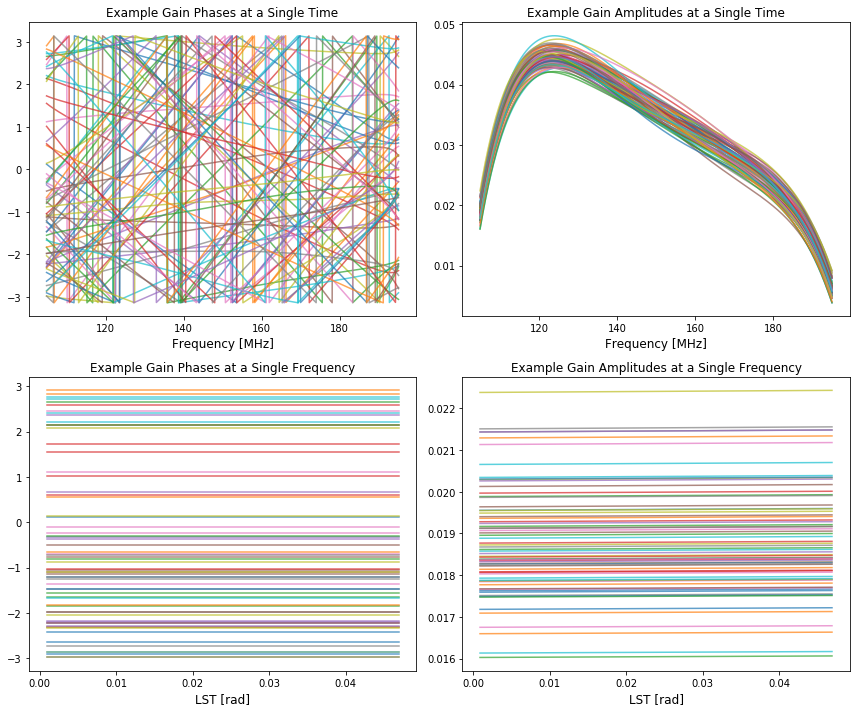

In [17]:
# take a peek at some of the gains
fig = plt.figure(figsize=(12,10))
axes = fig.subplots(2,2)

axes[0,0].set_title("Example Gain Phases at a Single Time", fontsize=12)
axes[0,1].set_title("Example Gain Amplitudes at a Single Time", fontsize=12)
axes[1,0].set_title("Example Gain Phases at a Single Frequency", fontsize=12)
axes[1,1].set_title("Example Gain Amplitudes at a Single Frequency", fontsize=12)

for ax in axes[0]:
    ax.set_xlabel("Frequency [MHz]", fontsize=12)
for ax in axes[1]:
    ax.set_xlabel("LST [rad]", fontsize=12)
    
freqs = hd.freqs[50:-50]/1e6
lsts = np.unique(hd.lst_array)

for ant in list(ants)[::]:
    gain = true_gains[ant][:,50:-50]
    
    axes[0,0].plot(freqs, np.angle(gain[0]), alpha=0.7)
    axes[0,1].plot(freqs, np.abs(gain[0]), alpha=0.7)
    axes[1,0].plot(lsts, np.angle(gain[:,0]), alpha=0.7)
    axes[1,1].plot(lsts, np.abs(gain[:,0]), alpha=0.7)
    
plt.tight_layout()
plt.show()

**Figure 1 |** Example gain amplitudes and phases. The top row shows the spectral distributions for a single time; the bottom row shows the temporal evolution at a single frequency. The gain amplitudes are set to vary by 10% over 8 hours; since this is for a much shorter duration, the gain amplitudes only slightly vary over the times used.

## Analysis

Push it through the analysis pipeline.

### Redundant Calibration and Absolute Calibration

In [18]:
%%time
# use HERAData object instead of file
flag_nchan_high, flag_nchan_low = (50,50)
_ = redcal.redcal_run(uncal_vis_file, pol_mode='2pol',
                      flag_nchan_high=flag_nchan_high, flag_nchan_low=flag_nchan_low,
                      solar_horizon=90, clobber=True, verbose=True)


Now running redundant calibration without antennas [] ...
Now calibrating ['xx'] polarization(s)...
    Now calibrating times 2451545.1611259277 through 2451545.1684332932 ...
Now calibrating ['yy'] polarization(s)...
    Now calibrating times 2451545.1611259277 through 2451545.1684332932 ...

Now saving firstcal gains to /lustre/aoc/projects/hera/Validation/test-2.1.0/visibilities/single_file/single_file_uncalibrated_visibilities.first.calfits
Now saving omnical gains to /lustre/aoc/projects/hera/Validation/test-2.1.0/visibilities/single_file/single_file_uncalibrated_visibilities.omni.calfits
Now saving omnical visibilities to /lustre/aoc/projects/hera/Validation/test-2.1.0/visibilities/single_file/single_file_uncalibrated_visibilities.omni_vis.uvh5


Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering
CPU times: user 58min 32s, sys: 4min 47s, total: 1h 3min 20s
Wall time: 14min 6s


In [19]:
%%time
abscal_output = abscal.post_redcal_abscal_run(uncal_vis_file,
                                              uncal_vis_file.replace(".uvh5", ".omni.calfits"),
                                              [single_file_master_vis],
                                              clobber=True, verbose=True)

Telescope RIMEz calculation is not in known_telescopes.




Now calibrating xx-polarization...

    Now calibrating times 2451545.1611259277 through 2451545.1684332932...


Mean of empty slice


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the dft algorithm


invalid value encountered in true_divide


...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.2852413798806218
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.162428003671495e-16
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 1.6747840789875892
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 1.0088381263678181e-15


divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide




Now calibrating yy-polarization...

    Now calibrating times 2451545.1611259277 through 2451545.1684332932...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the dft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm


invalid value encountered in true_divide


...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.07599956603169937
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.2443766799504683e-16
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 0.6267127227258744
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 3.9097431814341727e-16


divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice


CPU times: user 25min 48s, sys: 2min 13s, total: 28min 1s
Wall time: 5min 39s


In [20]:
# update omnical solutions
# update omnical solution
apply_cal.apply_cal(uncal_vis_file.replace(".uvh5", ".omni_vis.uvh5"),
                    uncal_vis_file.replace(".uvh5", ".abs_vis.uvh5"),
                    uncal_vis_file.replace(".uvh5", ".abs.calfits"),
                    uncal_vis_file.replace(".uvh5", ".omni.calfits"),
                    clobber=True)

Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


### Calibration Smoothing

In [21]:
smooth_cal_kwargs = {"freq_scale" : 10.0, "time_scale" : 1800.0, "tol" : 1e-9, "maxiter" : 100,
                     "window" : "tukey", "alpha" : 0.3}
history_update = "Smoothed with parameters: " + ", ".join("{}={}".format(item, value)
                                                          for item, value in smooth_cal_kwargs.items())
cs = smooth_cal.CalibrationSmoother([uncal_vis_file.replace(".uvh5", ".abs.calfits")],
                                    pick_refant=True, verbose=True)
# mirror_sigmas was an option in an old version of smooth_cal; is there an equivalent now?
# skip_wgt was also an option but isn't anymore
# IDR2 alpha setting was 0.3, but func default is 0.5
cs.time_freq_2D_filter(**smooth_cal_kwargs)
cs.write_smoothed_cal(output_replace=(".abs.", ".smoothed_abs."),
                      add_to_history=history_update, clobber=True)

Now loading calibration files...
Now setting up gain and flag grids...
Now picking reference antenna(s)...


Mean of empty slice


Reference Antenna 30 selected for Jxx.
Reference Antenna 36 selected for Jyy.
    Now filtering antenna 0 Jxx in time and frequency...
    Now filtering antenna 0 Jyy in time and frequency...
    Now filtering antenna 1 Jxx in time and frequency...
    Now filtering antenna 1 Jyy in time and frequency...
    Now filtering antenna 2 Jxx in time and frequency...
    Now filtering antenna 2 Jyy in time and frequency...
    Now filtering antenna 3 Jxx in time and frequency...
    Now filtering antenna 3 Jyy in time and frequency...
    Now filtering antenna 4 Jxx in time and frequency...
    Now filtering antenna 4 Jyy in time and frequency...
    Now filtering antenna 5 Jxx in time and frequency...
    Now filtering antenna 5 Jyy in time and frequency...
    Now filtering antenna 6 Jxx in time and frequency...
    Now filtering antenna 6 Jyy in time and frequency...
    Now filtering antenna 7 Jxx in time and frequency...
    Now filtering antenna 7 Jyy in time and frequency...
    Now fi

Mean of empty slice


In [22]:
# update omnical solution
apply_cal.apply_cal(uncal_vis_file.replace(".uvh5", ".omni_vis.uvh5"),
                    uncal_vis_file.replace(".uvh5", ".smoothed_abs_vis.uvh5"),
                    uncal_vis_file.replace(".uvh5", ".smoothed_abs.calfits"),
                    uncal_vis_file.replace(".uvh5", ".omni.calfits"),
                    clobber=True)

Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


### Simple Calibration

In [23]:
# removing *only* freq dependence
# load in abscal gains
simple_cal = io.HERACal(uncal_vis_file.replace(".uvh5", ".abs.calfits"))
# read the gains
gains = simple_cal.read()[0]

# get the size of a frequency channel
df = np.median(np.diff(simple_cal.freqs))

# make a key for choosing unflagged frequency channels for a 2d array
no_flag = (slice(None), slice(flag_nchan_low, -flag_nchan_high))

# calibrate each antenna to a single delay and offset
simple_gains = {}
for ant, gain in gains.items():
    dly, offset = hera_cal.utils.fft_dly(gain[no_flag]/np.abs(gain[no_flag]), df, f0=simple_cal.freqs[no_flag[1]][0])
    amp = np.abs(gain[no_flag]).mean(axis=1, keepdims=True)
    simple_gains[ant] = amp*np.exp(1j*(2*np.pi*dly*simple_cal.freqs+offset))


simple_cal.update(gains=simple_gains)
# update history
# XXX what should go in the new history string?
# save to disk
simple_cal.write_calfits(uncal_vis_file.replace(".uvh5",".simple_cal.calfits"), clobber=True)

In [24]:
# apply simple calibration to vis solutions
apply_cal.apply_cal(uncal_vis_file.replace(".uvh5", ".omni_vis.uvh5"),
                    uncal_vis_file.replace(".uvh5", ".simple_cal_vis.uvh5"),
                    uncal_vis_file.replace(".uvh5", ".simple_cal.calfits"),
                    uncal_vis_file.replace(".uvh5", ".omni.calfits"),
                    clobber=True)

Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


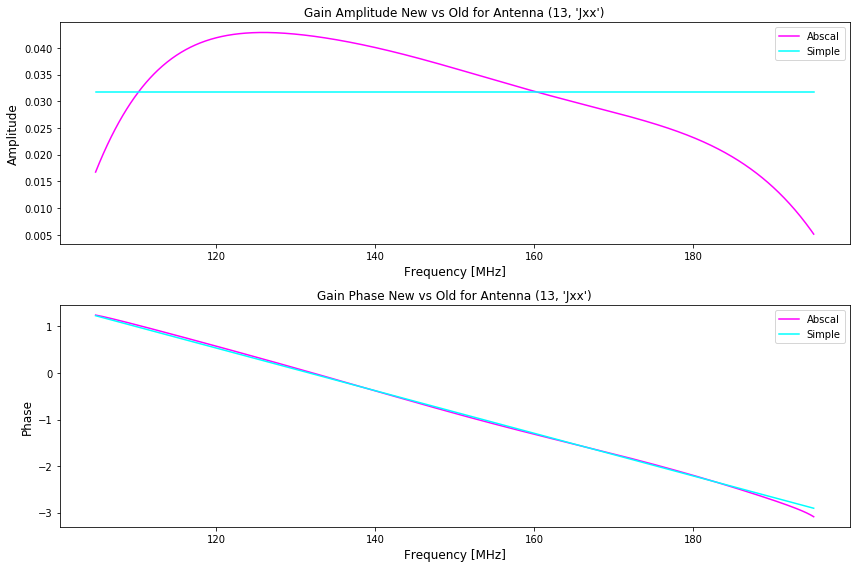

In [25]:
ant = (13, "Jxx")
plot_freqs = simple_cal.freqs[no_flag[1]]/1e6

fig = plt.figure(figsize=(12,8))
axes = fig.subplots(2,1)

labels = ("Amplitude", "Phase")
    
axes[0].plot(plot_freqs, np.abs(gains[ant][no_flag][0]), label="Abscal", color="magenta")
axes[0].plot(plot_freqs, np.abs(simple_gains[ant][no_flag][0]), label="Simple", color="cyan")
axes[1].plot(plot_freqs, np.angle(gains[ant][no_flag][0]), label="Abscal", color="magenta")
axes[1].plot(plot_freqs, np.angle(simple_gains[ant][no_flag][0]), label="Simple", color="cyan")

for i, label in enumerate(labels):
    axes[i].set_xlabel("Frequency [MHz]", fontsize=12)
    axes[i].set_ylabel(label, fontsize=12)
    axes[i].set_title("Gain {} New vs Old for Antenna {}".format(label, ant), fontsize=12)
    axes[i].legend()

plt.tight_layout()
plt.show()

**Figure 2 |** Comparison of gain solutions from absoluate calibration and simple calibration (frequency-independent amplitude and delay).

### Gain Visualizations

In [26]:
# load in the smoothed calibration data
smoothed_cal = io.HERACal(uncal_vis_file.replace(".uvh5", ".smoothed_abs.calfits"))
smooth_gains = smoothed_cal.read()[0]

# get the abscal gains
abscal_gains = abscal_output.build_calcontainers()[0]

# choose a reference antenna
refant = {"Jxx" : (30, "Jxx"), "Jyy" : (36, "Jyy")}

# rephase the gains
def rephase_gains(gains, refant):
    return {ant: gains[ant] * np.abs(gains[refant[ant[1]]]) / gains[refant[ant[1]]] for ant in gains.keys()}

rephased_abs_gains = rephase_gains(abscal_gains, refant)
rephased_smooth_gains = rephase_gains(smooth_gains, refant)
rephased_true_gains = rephase_gains(true_gains, refant)

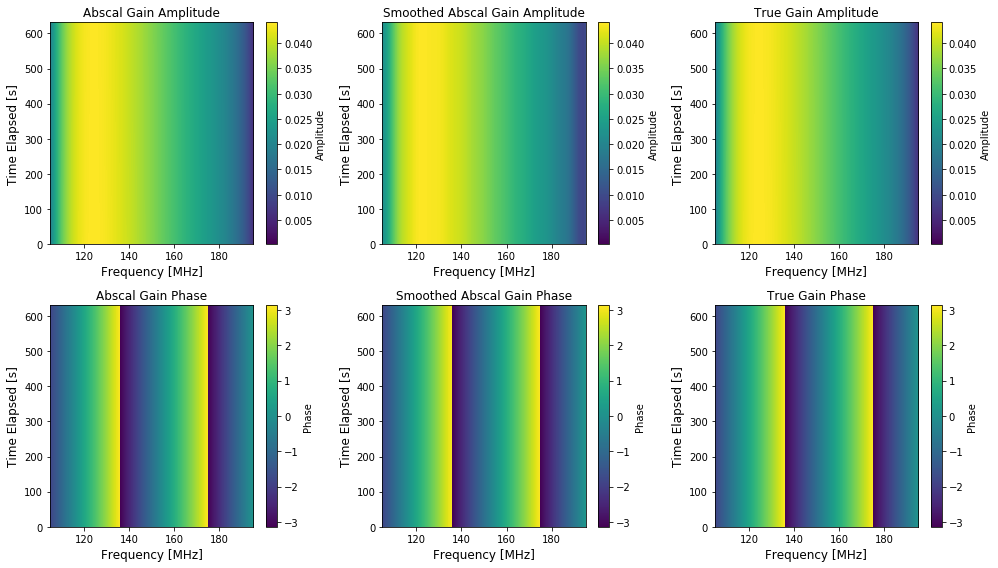

The above plots are for antenna: (24, 'Jxx')


In [27]:
# choose an antenna to inspect
ant = list(rephased_abs_gains.keys())[np.random.randint(0,len(ants))]

# setup objects for plotting
plot_times = (times_to_use - times_to_use[0])*units.day.to("s")

# get extent
extent = [plot_freqs.min(), plot_freqs.max(), plot_times.min(), plot_times.max()]

# get bounds
amp_bounds = (np.abs(true_gains[ant]).min(),np.abs(true_gains[ant]).max())
#phs_bounds = (-np.angle(rephased_true_gains[ant]).min(), np.angle(rephased_true_gains[ant]).max())
phs_bounds = (-np.pi, np.pi)
bounds = (amp_bounds, phs_bounds)
modes = ("abs", "phs")

# make gain dict
gains = {"Abscal" : rephased_abs_gains[ant][no_flag],
         "Smoothed Abscal" : rephased_smooth_gains[ant][no_flag],
         "True" : rephased_true_gains[ant][no_flag]}

# make the plot
gain_plot_file = os.path.join(plot_path, "single_file_gains_{}_{}.pdf".format(ant[0],ant[1]))
save_paths = [gain_plot_file, gain_plot_file.replace(".pdf",".png")]
plot_gain_waterfalls(gains, extent, bounds, modes, save_path=save_paths)
print("The above plots are for antenna: {}".format(ant))

**Figure 3 |** Waterfall plots for the abscal and smoothed abscal gain solutions (amplitude and phase), as well as the true gains. The gains have been rephased to a common antenna for direct comparison.

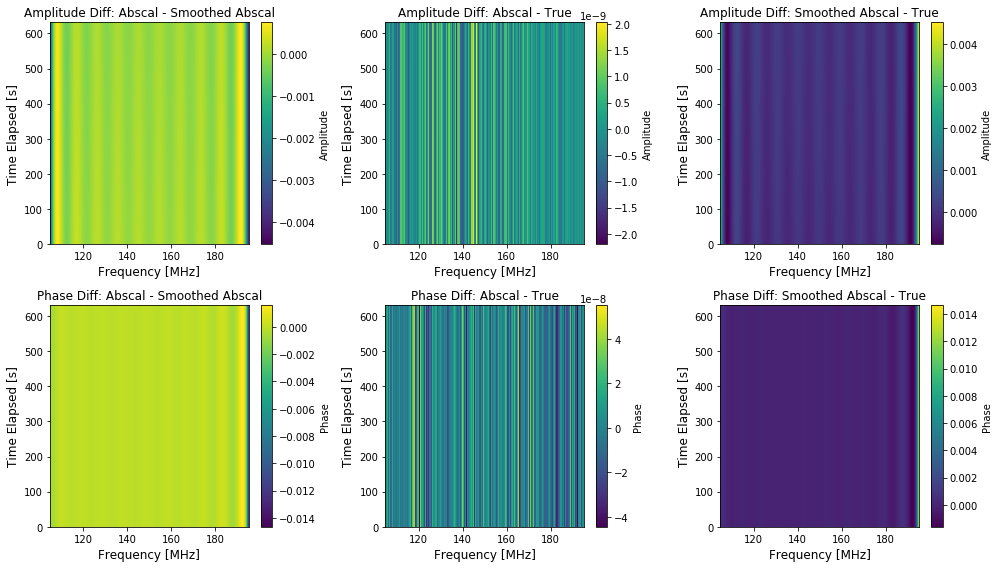

The above plots are for antenna: (24, 'Jxx')


In [43]:
# plot the diffs
gain_diff_plot_file = os.path.join(plot_path, "single_file_gain_diff_{}_{}.pdf".format(ant[0],ant[1]))
save_paths = [gain_diff_plot_file, gain_diff_plot_file.replace(".pdf",".png")]
plot_gain_diffs(gains, extent, save_path=save_paths)
print("The above plots are for antenna: {}".format(ant))

**Figure 4 |** Waterfall plots for the differenced gains. The leftmost column compares the abscal gain solutions to the true gains; the center column compares the smoothed abscal solutions to the true gains; the rightmost column compares the smoothed abscal solutions to the unsmoothed abscal solutions. Note that the abscal gain solutions are accurate to machine precision.

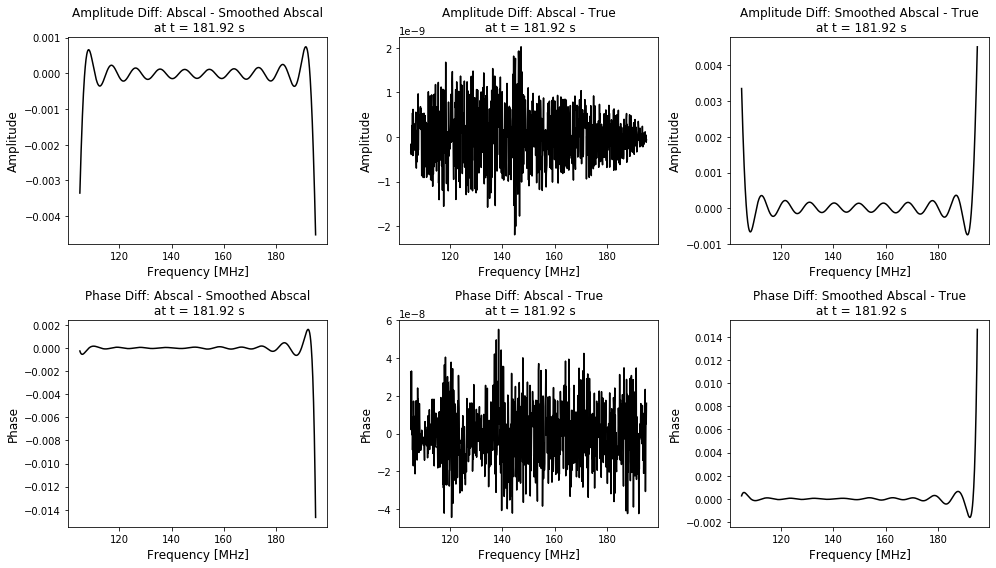

The above plots are for antenna: (24, 'Jxx')


In [46]:
# plot the diffs at a fixed time
gain_diff_plot_file = os.path.join(plot_path, "single_file_single_time_gain_diff_{}_{}.pdf".format(ant[0],ant[1]))
save_paths = [gain_diff_plot_file, gain_diff_plot_file.replace(".pdf",".png")]
plot_gain_diffs_1d(gains, plot_freqs, plot_times, save_path=save_paths)
print("The above plots are for antenna: {}".format(ant))

**Figure 5 |** Differenced gains at a single time.

## Power Spectra

In this section, we inspect the power spectrum estimates for the "single file" set of data.

In [33]:
del abscal_output, simple_cal

In [47]:
# define the cosmology
cosmo = astropyPlanck15_for_hera_pspec()

# choose only the unflagged frequencies
freq_slice = slice(flag_nchan_low, -flag_nchan_high)

# load beam-dependent normalization data
with h5py.File(omegas_data_path, 'r') as h5f:
    Omega = h5f['Omega'][()][freq_slice]
    Omegapp = h5f['Omegapp'][()][freq_slice]

beam = hera_pspec.pspecbeam.PSpecBeamFromArray(Omega, Omegapp, np.unique(hd.freqs[freq_slice]), cosmo=cosmo)

# wrapper for pspec_run
def calc_pspec(vis_file, outfile, spw_ranges=None, blpairs=None):
    uvdI = get_VI_data(vis_file)
    _ = hera_pspec.pspecdata.pspec_run([uvdI, uvdI], outfile, file_type="uvh5",
                                       taper="blackman-harris", beam=beam, cosmo=cosmo,
                                       spw_ranges=spw_ranges, blpairs=blpairs, pol_pairs=[('pI','pI')],
                                       Jy2mK=True, exclude_cross_bls=True, 
                                       overwrite=True, verbose=True)

In [48]:
%%time
smooth_pspec_file = os.path.join(spec_path, "single_file_smooth_pspec.psc")
smoothed_abs_vis_file = uncal_vis_file.replace(".uvh5", ".smoothed_abs_vis.uvh5")

master_pspec_file = os.path.join(spec_path, "single_file_master_pspec.psc")

eor_pspec_file = os.path.join(spec_path, "single_file_eor_pspec.psc")

simple_pspec_file = os.path.join(spec_path, "single_file_simple_pspec.psc")
simple_cal_vis_file = uncal_vis_file.replace(".uvh5", ".simple_cal_vis.uvh5")

uncal_pspec_file = os.path.join(spec_path, "single_file_uncal_pspec.psc")

abscal_pspec_file = os.path.join(spec_path, "single_file_abscal_pspec.psc")
abscal_vis_file = uncal_vis_file.replace(".uvh5", ".abs_vis.uvh5")

vis_files = [uncal_vis_file, single_file_master_vis, single_file_eor_vis, 
             simple_cal_vis_file, smoothed_abs_vis_file, abscal_vis_file]
pspec_files = [uncal_pspec_file, master_pspec_file, eor_pspec_file, 
               simple_pspec_file, smooth_pspec_file, abscal_pspec_file]

spws = [(400,600)]
blps = [((0,1),(0,1)),((0,15),(0,15)),((0,32),(0,32))]
for vis_file, pspec_file in zip(vis_files, pspec_files):
    print("Extracting spectrum from {}".format(os.path.basename(vis_file)))
    calc_pspec(vis_file, pspec_file, spws, blps)

Extracting spectrum from single_file_uncalibrated_visibilities.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Cannot convert dset 1 Jy -> mK because vis_units = mK
Opening /lustre/aoc/projects/hera/Validation/test-2.1.0/spectra/single_file/single_file_uncal_pspec.psc in transactional mode

Setting spectral range: (400, 600)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((0, 1), (0, 1))
pol: (1, 1)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (0, 15))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 32), (0, 32))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...
Storing dset0_x_dset1
Extracting spectrum from single_file_true_visibilities.uvh5
Cannot convert dset 1 Jy -> mK because vis_units = mK
Opening /lustre/aoc/projects/hera/Validation/test-2.1.0/spectra/single_file/single_file_master_pspec.psc in transactional mode

Setting spectral range: (400, 600)

Using polariza

In [49]:
def get_pspec(pspec_file, key, fold=True, avg=True, return_kparas=True, return_kperps=False):
    psc = hera_pspec.container.PSpecContainer(pspec_file, keep_open=False)
    uvp = psc.get_pspec(psc.groups()[0])[0]
    if fold:
        uvp.fold_spectra()
    pspec = uvp.get_data(key)
    if avg:
        pspec = pspec.mean(axis=0)
    output = [pspec,]
    if return_kparas:
        output.append(uvp.get_kparas(0))
    if return_kperps:
        output.append(uvp.get_kperps(0))
    return output

In [50]:
key = (0, blps[2], 'pI')
spectra, kparas = [], []
for pspec_file in pspec_files:
    output = get_pspec(pspec_file, key)
    spectra.append(output[0])
    kparas.append(output[1])

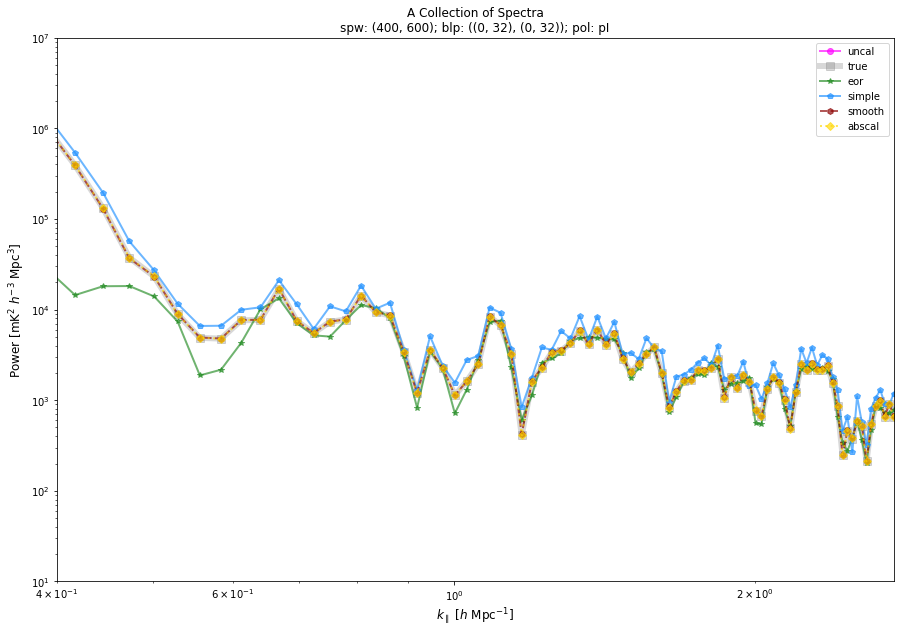

In [51]:
labels = ["uncal", "true", "eor", "simple", "smooth", "abscal"]
colors = ["magenta", "gray", "forestgreen", "dodgerblue", "darkred", "gold"]
markers = ["o", "s", "*", "p", "h", "D"]
linestyles = ["-", "-", "-", "-", "--", ":"]
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
ax.set_title("A Collection of Spectra\nspw: {}; blp: {}; pol: {}".format(spws[key[0]],
                                                                         key[1], key[2]), fontsize=12)

ax.set_xlim(0.4, kparas[0].max())
ax.set_ylim(10, 10**7)

for j, label in enumerate(labels):
    if label in ("simple", "uncal"):
        pass
    ms = 8 if label=="true" else 6
    alpha = 0.3 if label=="true" else 0.65
    lw = 6 if label=="true" else 2
    ax.loglog(kparas[j], np.abs(spectra[j]), lw=lw, marker=markers[j], ms=ms, 
              label=label, color=colors[j], ls=linestyles[j], alpha=alpha)
ax.legend()
plt.show()
plot_save_path = "/lustre/aoc/projects/hera/Validation/test-2.1.0/plots/single_file_pspec.pdf"
fig.savefig(plot_save_path)

**Figure 6 |** Power spectrum estimates from various visibility data sets for a "single file" worth of data (60 integrations). It is somewhat difficult to tell, but the smoothed abscal results seem to exactly agree with the unsmoothed abscal results. Somewhat easier to see is the high level of agreement between the power spectrum estimates from the absolutely calibrated visibilities and the true visibilities.

## Full Day Results

In this section, we examine the resulting power spectra from performing the above analysis on a data set spanning 8 hours. Python scripts for all of the data preparation and analysis can be found in the following directory on the NRAO server: `/lustre/aoc/projects/hera/Validation/test-2.1.0/` (see the scripts with `_multiprocessing` in their names for power spectrum retrieval; see the `preparation` scripts in the `master_data` subdirectory to see how the raw simulation files were modified to work with a modified version of the pipeline's makeflow; see the scripts in the `makeflow` subdirectory to see how the makeflow for this test was configured; finally, note that the EoR component was done separately&mdash;this was just because I forgot to set up the EoR files the first time around). A brief summary of the test steps is as follows: 
 
Visibilities were simulated for 24 hours over the full HERA H1C bandwidth (100 MHz - 200 MHz) over 1024 frequency channels with a uniform integration time of 10.7 seconds. Three sets of visibilities were simulated: one component is for diffuse foregrounds, simulated using the eGSM diffuse sky model; another component is for point-source visibilities, using the parameters listed in the GLEAM catalog; the final component is for the EoR signal, with a power spectrum amplitude that goes like $P(k) = A_0 k^{-2}$; each visibility component contains simulated observations for four polarizations (XX, XY, YX, YY). The simulations were carried out with the `RIMEz` simulation package, using the HERA dipole beam model. The individual visibility files were added together to form the "true" sky model, but only the first eight hours of the simulated data were used for this test. Finally, note that the visibility simulations are noiseless and perfectly calibrated. 
 
The true visibilities were uncalibrated using simulated gains. The gains were simulated on a per-antenna basis using the `gen_gains` function found in the `hera_sim.sigchain` module for each linear polarization. Additionally, each antenna gain was assigned a constant phase offset and had its amplitude vary linearly by 10 percent over eight hours. 
 
The uncalibrated visibilities were pushed through the analysis pipeline using a modified version of the makeflow (except for the RFI flagging step, since there is no RFI in the simulated data)&mdash;part of this test is to validate the performance of the (post-redundant calibration) absolute calibration step and the calibration smoothing step. In addition to absolute calibration, we performed a simple calibration in this test by modifying the absolutely-calibrated gain solutions to have a frequency-independent amplitude and delay.  
 
The power spectrum estimates were obtained using the `pspec_run` function in the `hera_pspec.pspecdata` module. This test used six spectral windows over the full bandwidth (except for the first and last 50 channels, which were flagged for the redundant calibration step) and a Blackman-Harris taper for calculating the power spectrum estimates. We obtained power spectrum estimates for seven sets of visibilities: perfectly calibrated (true), uncalibrated, redundantly calibrated, absolutely calibrated, absolutely calibrated with time and frequency smoothing, simply calibrated, and EoR-only. We present the results on a per-spectral-window basis, showing both a scatter plot of power spectrum estimates on a per-baseline basis, as well as a line plot that has been averaged over all baselines. Each power spectrum presented has been incoherently averaged over the full eight hours.

In [52]:
# load in the true gains
true_gain_file = os.path.join(plot_path.replace("plots","master_data"), "true_gains.npy")
assert os.path.exists(true_gain_file)
true_gains = np.load(true_gain_file, allow_pickle=True)[None][0]

In [53]:
# get the times and frequencies for plotting

# first, get a glob of visibility files, there should be 269 for each type of calibration
vis_files = sorted(glob.glob(os.path.join(pipeline_output_path, "*.uncal.uvh5")))
assert len(vis_files) == 269

# now load in the first one to get the initial time and the frequencies
times = []
for vis_file in vis_files:
    uvd = UVData()
    uvd.read_uvh5(vis_file)
    times.append(np.unique(uvd.time_array))

times = np.array(times)
times = times.reshape(times.size)
freqs = uvd.freq_array[0][flag_nchan_low:-flag_nchan_high]/1e6 # MHz

# don't need the UVData object anymore
del uvd

# now make the extent for the waterfall plots
extent = [freqs.min(), freqs.max(), (times[-1]-times[0])*units.day.to("hr"), 0]

Telescope RIMEz calculation is not in known_telescopes.


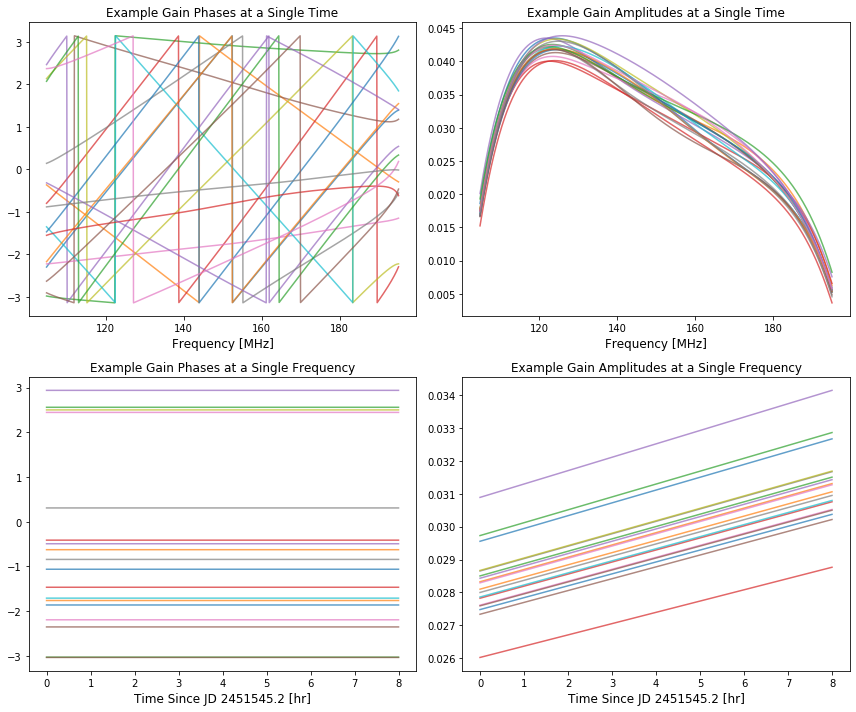

In [54]:
# take a peek at some of the gains
fig = plt.figure(figsize=(12,10))
axes = fig.subplots(2,2)

axes[0,0].set_title("Example Gain Phases at a Single Time", fontsize=12)
axes[0,1].set_title("Example Gain Amplitudes at a Single Time", fontsize=12)
axes[1,0].set_title("Example Gain Phases at a Single Frequency", fontsize=12)
axes[1,1].set_title("Example Gain Amplitudes at a Single Frequency", fontsize=12)

for ax in axes[0]:
    ax.set_xlabel("Frequency [MHz]", fontsize=12)
for ax in axes[1]:
    ax.set_xlabel("Time Since JD {:8.1f} [hr]".format(times[0]), fontsize=12)

for ant in list(ants)[::4]:
    gain = true_gains[ant][no_flag]
    
    axes[0,0].plot(freqs, np.angle(gain[0]), alpha=0.7)
    axes[0,1].plot(freqs, np.abs(gain[0]), alpha=0.7)
    axes[1,0].plot((times-times[0])*units.day.to("hr"), np.angle(gain[:,37]), alpha=0.7)
    axes[1,1].plot((times-times[0])*units.day.to("hr"), np.abs(gain[:,37]), alpha=0.7)
    
plt.tight_layout()
plt.show()

**Figure 7 |** Gains for the full day. Note that the simulated gains were made to have their amplitudes vary linearly by 10 percent over the course of 8 hours (but have their phases remain constant in time).

### Calibration Results

In [55]:
abscal_glob = sorted(glob.glob(os.path.join(pipeline_output_path, "*.abs.calfits")))
smoothcal_glob = sorted(glob.glob(os.path.join(pipeline_output_path, "*.smooth_abs.calfits")))
assert len(abscal_glob) == len(smoothcal_glob) and len(abscal_glob) != 0

In [56]:
ac = io.HERACal(abscal_glob[0])
ac_gains = ac.read()[0]
ants = list(ac_gains.keys())

# no particular reason for choosing these antennas as a reference
refant = {"Jxx" : (13, "Jxx"), "Jyy" : (22, "Jyy")}

# initialize a dictionary of gains for the full day
abscal_gains = {ant : [] for ant in ants}
smoothcal_gains = {ant : [] for ant in ants}

# loop over all the abscal and smoothcal files
for abscal_file, smoothcal_file in zip(abscal_glob, smoothcal_glob):
    # instantiate HERACal objects for each file
    ac = io.HERACal(abscal_file)
    sc = io.HERACal(smoothcal_file)
    
    # load in the gains
    ac_gains = ac.read()[0]
    sc_gains = sc.read()[0]
    
    # update the gain dictionaries
    for ant in ants:
        abscal_gains[ant].append(ac_gains[ant])
        smoothcal_gains[ant].append(sc_gains[ant])

# now reshape the gain arrays
for ant in ants:
    ac_gains = np.array(abscal_gains[ant])
    sc_gains = np.array(smoothcal_gains[ant])
    
    new_shape = (ac_gains.shape[0] * ac_gains.shape[1], ac_gains.shape[2])
    abscal_gains[ant] = ac_gains.reshape(new_shape)
    smoothcal_gains[ant] = sc_gains.reshape(new_shape)
    
# now rephase the gains
abscal_gains = rephase_gains(abscal_gains, refant)
smoothcal_gains = rephase_gains(smoothcal_gains, refant)
true_gains = rephase_gains(true_gains, refant)

In [57]:
# choose an antenna to inspect
ant = ants[np.random.randint(0,len(ants))]

gain_dict = {"Abscal" : abscal_gains[ant][no_flag], 
             "Smoothed Abscal" : smoothcal_gains[ant][no_flag], 
             "True" : true_gains[ant][no_flag]}

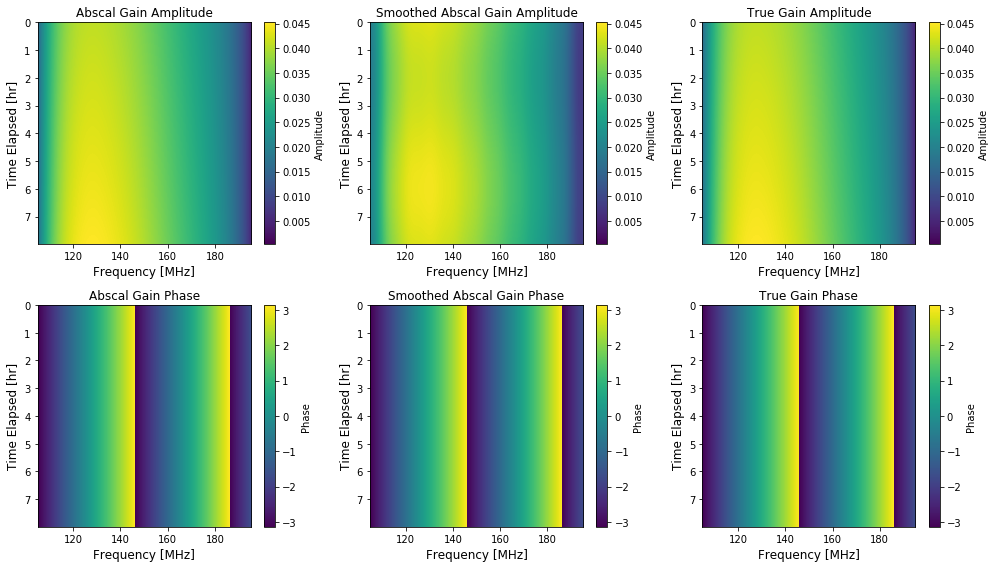

The above plots are for antenna: (9, 'Jyy')


In [58]:
# get bounds
amp_bounds = (np.abs(true_gains[ant]).min(), np.abs(true_gains[ant]).max())
phs_bounds = (-np.pi, np.pi)
bounds = (amp_bounds, phs_bounds)
modes = ("abs", "phs")

# make the plot
gain_plot_file = os.path.join(plot_path, "full_day_gains_{}_{}.pdf".format(ant[0],ant[1]))
save_paths = [gain_plot_file, gain_plot_file.replace(".pdf",".png")]
plot_gain_waterfalls(gain_dict, extent, bounds, modes, save_path=save_paths, time_units="hr")
print("The above plots are for antenna: {}".format(ant))

**Figure 8 |** Gain amplitude and phase waterfalls for the absolutely calibrated gain solutions, the smoothed versions thereof, and the true gains.

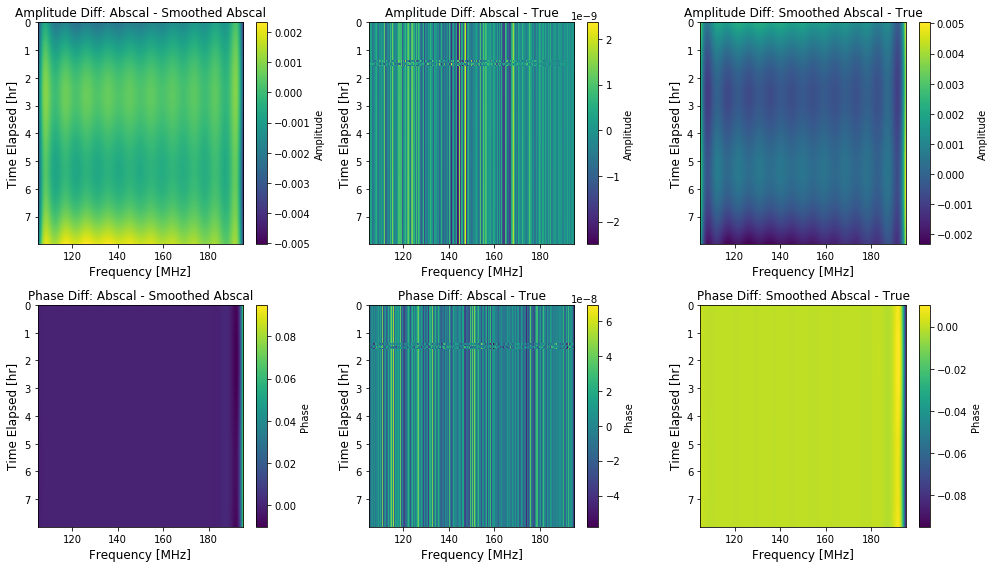

The above plots are for antenna: (9, 'Jyy')


In [59]:
# plot the diffs
gain_diff_plot_file = os.path.join(plot_path, "full_day_gain_diff_{}_{}.pdf".format(ant[0],ant[1]))
save_paths = [gain_diff_plot_file, gain_diff_plot_file.replace(".pdf", ".png")]
plot_gain_diffs(gain_dict, extent, save_path=save_paths, time_units="hr")
print("The above plots are for antenna: {}".format(ant))

**Figure 9 |** Waterfall plots for the amplitudes and phases of the differenced sets of gains. The leftmost column shows the comparison between the abscal solutions and the smoothed solutions; the other columns show the differences with the true gains. Note that the absolutely calibrated gain solutions are correct to machine precision, but the smoothed gain solutions introduce errors up to about the 10 percent level. (Perhaps important to note is that the errors in the smoothed solutions are only at about the 2 percent level when the gains do not vary in time.)

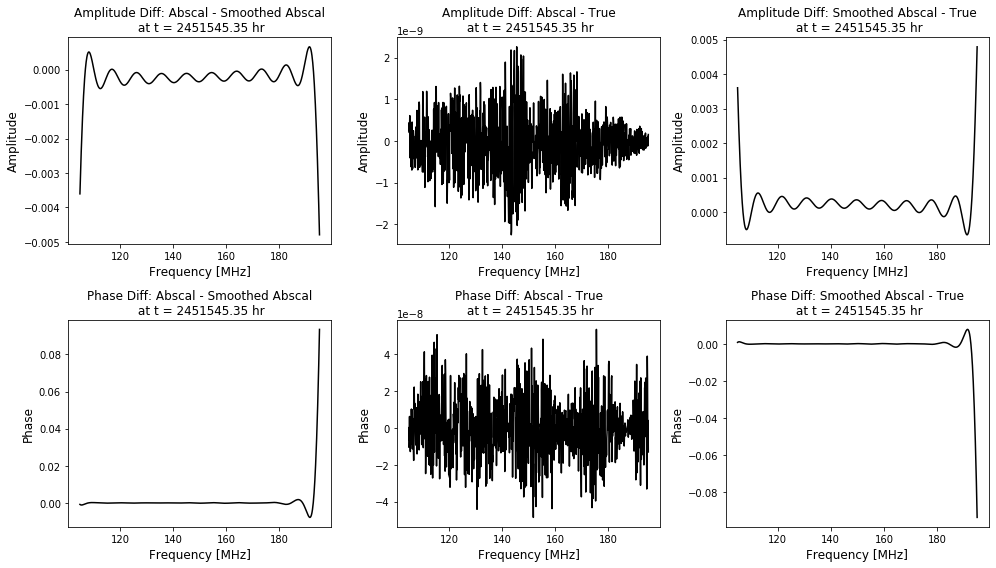

The above plots are for antenna: (9, 'Jyy')


In [60]:
# plot the diffs at a single time
gain_diff_plot_file = os.path.join(plot_path, "full_day_single_time_gain_diff_{}_{}.pdf".format(ant[0],ant[1]))
save_paths = [gain_diff_plot_file, gain_diff_plot_file.replace(".pdf", ".png")]
plot_gain_diffs_1d(gain_dict, freqs, times, save_path=save_paths, time_units="hr")
print("The above plots are for antenna: {}".format(ant))

**Figure 10 |** Same plots as above, but at a single time.

### Power Spectrum Results

In this section, we load and visualize the power spectrum estimations for every data set for the full eight hours investigated in this test.

In [167]:
simple_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*simple*.psc")))
abs_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.abs_vis.psc")))
smooth_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*smooth*.psc")))
uncal_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*uncal.psc")))
omni_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*omni*.psc")))
true_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*true.psc")))
eor_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.eor.psc")))
fg_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.fg_only.psc")))

In [168]:
globs = (simple_spec_glob, abs_spec_glob, smooth_spec_glob, uncal_spec_glob, 
         omni_spec_glob, true_spec_glob, eor_spec_glob, fg_spec_glob)

In [169]:
for spec_glob in globs:
    print(len(spec_glob))

269
269
269
269
269
269
269
98


In [170]:
%%time
# incoherently average all the spectra
# each spw has 154 channels, but we'll be folding the spectra

# initialize some dictionaries
simple_cal_spectra = {spw: {} for spw in range(6)}
abs_cal_spectra = {spw: {} for spw in range(6)}
smooth_abs_cal_spectra = {spw: {} for spw in range(6)}
omni_cal_spectra = {spw: {} for spw in range(6)}
uncal_spectra = {spw: {} for spw in range(6)}
true_spectra = {spw: {} for spw in range(6)}
eor_spectra = {spw: {} for spw in range(6)}
fg_spectra = {spw: {} for spw in range(6)}

# some stuff for making things easy
spectra = {"simple" : simple_cal_spectra,
           "abs" : abs_cal_spectra,
           "smooth" : smooth_abs_cal_spectra, 
           "uncal" : uncal_spectra,
           "omni" : omni_cal_spectra,
           "true" : true_spectra,
           "eor" : eor_spectra,
           "fg" : fg_spectra}

labels = tuple(spectra.keys())
assert len(labels) == len(globs)

skip_data = ("uncal", "omni")

for label, spec_glob in zip(labels, globs):
    if label in skip_data:
        continue
    spec_by_spw = spectra[label]
    for spec_file in spec_glob:
        psc = hera_pspec.container.PSpecContainer(spec_file, keep_open=False)
        uvp = psc.get_pspec(psc.groups()[0])[0]
        uvp.fold_spectra()
        for key in uvp.get_all_keys():
            spw = key[0]
            blp = key[1]
            try:
                spec_by_spw[spw][blp].append(uvp.get_data(key))
            except KeyError:
                spec_by_spw[spw][blp] = [uvp.get_data(key),]
        
del psc, uvp

CPU times: user 10min 10s, sys: 2min 51s, total: 13min 1s
Wall time: 25min 2s


In [171]:
# the spectra dictionaries should have 6 spws, and each spw should have Nblp dictionaries
# each dictionary spectra[spec_file][spw][blp] should have a list with length Nfiles
# each entry in the list should have shape (10, 76)
for label, spec_dict in spectra.items():
    if label in skip_data:
        continue
    for spw in spec_dict.keys():
        for blp in spec_dict[spw].keys():
            for spec in spec_dict[spw][blp]:
                assert spec.shape == (10,76)
                
# now let's re-shape from (Nfiles, Ntimes, Ndlys) to (Nfiles * Ntimes, Ndlys)
for label, spec_dict in spectra.items():
    if label in skip_data:
        continue
    for spec_by_spw in spec_dict.values():
        for blp, spec in spec_by_spw.items():
            spec = np.array(spec)
            new_shape = (spec.shape[0] * spec.shape[1], spec.shape[2])
            spec_by_spw[blp] = spec.reshape(new_shape)
            
# in the end we have an array of shape (Nspw, Nblps, Nfiles * Ntimes, Ndlys)

In [172]:
# get the spectral window edges, k_parallel values, and delays
psc = hera_pspec.container.PSpecContainer(smooth_spec_glob[0], keep_open=False)
uvp = psc.get_pspec(psc.groups()[0])[0]
uvp.fold_spectra()
spw_edges = [(spw[0], spw[1]) for spw in uvp.get_spw_ranges()]
k_paras = [uvp.get_kparas(j) for j in range(6)]
dlys = [uvp.get_dlys(j) for j in range(6)]

# now get the expected power spectrum for each spectral window
aliased_spectra = {}
for j, kparas in enumerate(k_paras):
    # get the frequencies in the spectral window
    spw = uvp.freq_array[j*154 : (j+1)*154] # 154 channels per spectral window
    
    # get redshift at band-center
    z = cosmo.f2z(np.mean(spw))
    
    # get co-moving distances sampled along LoS
    sampled_distances = np.array([cosmo.DC(z) for z in cosmo.f2z(spw)])
    
    # convert to approximate sampling frequency
    ks_est = np.pi/np.mean(np.abs(np.diff(sampled_distances)))

    # calculate aliased power spectrum
    aliased_spectra[j] = aliased_power_spectrum(kparas, ks_est, z, cosmo=cosmo)
    
del psc, uvp

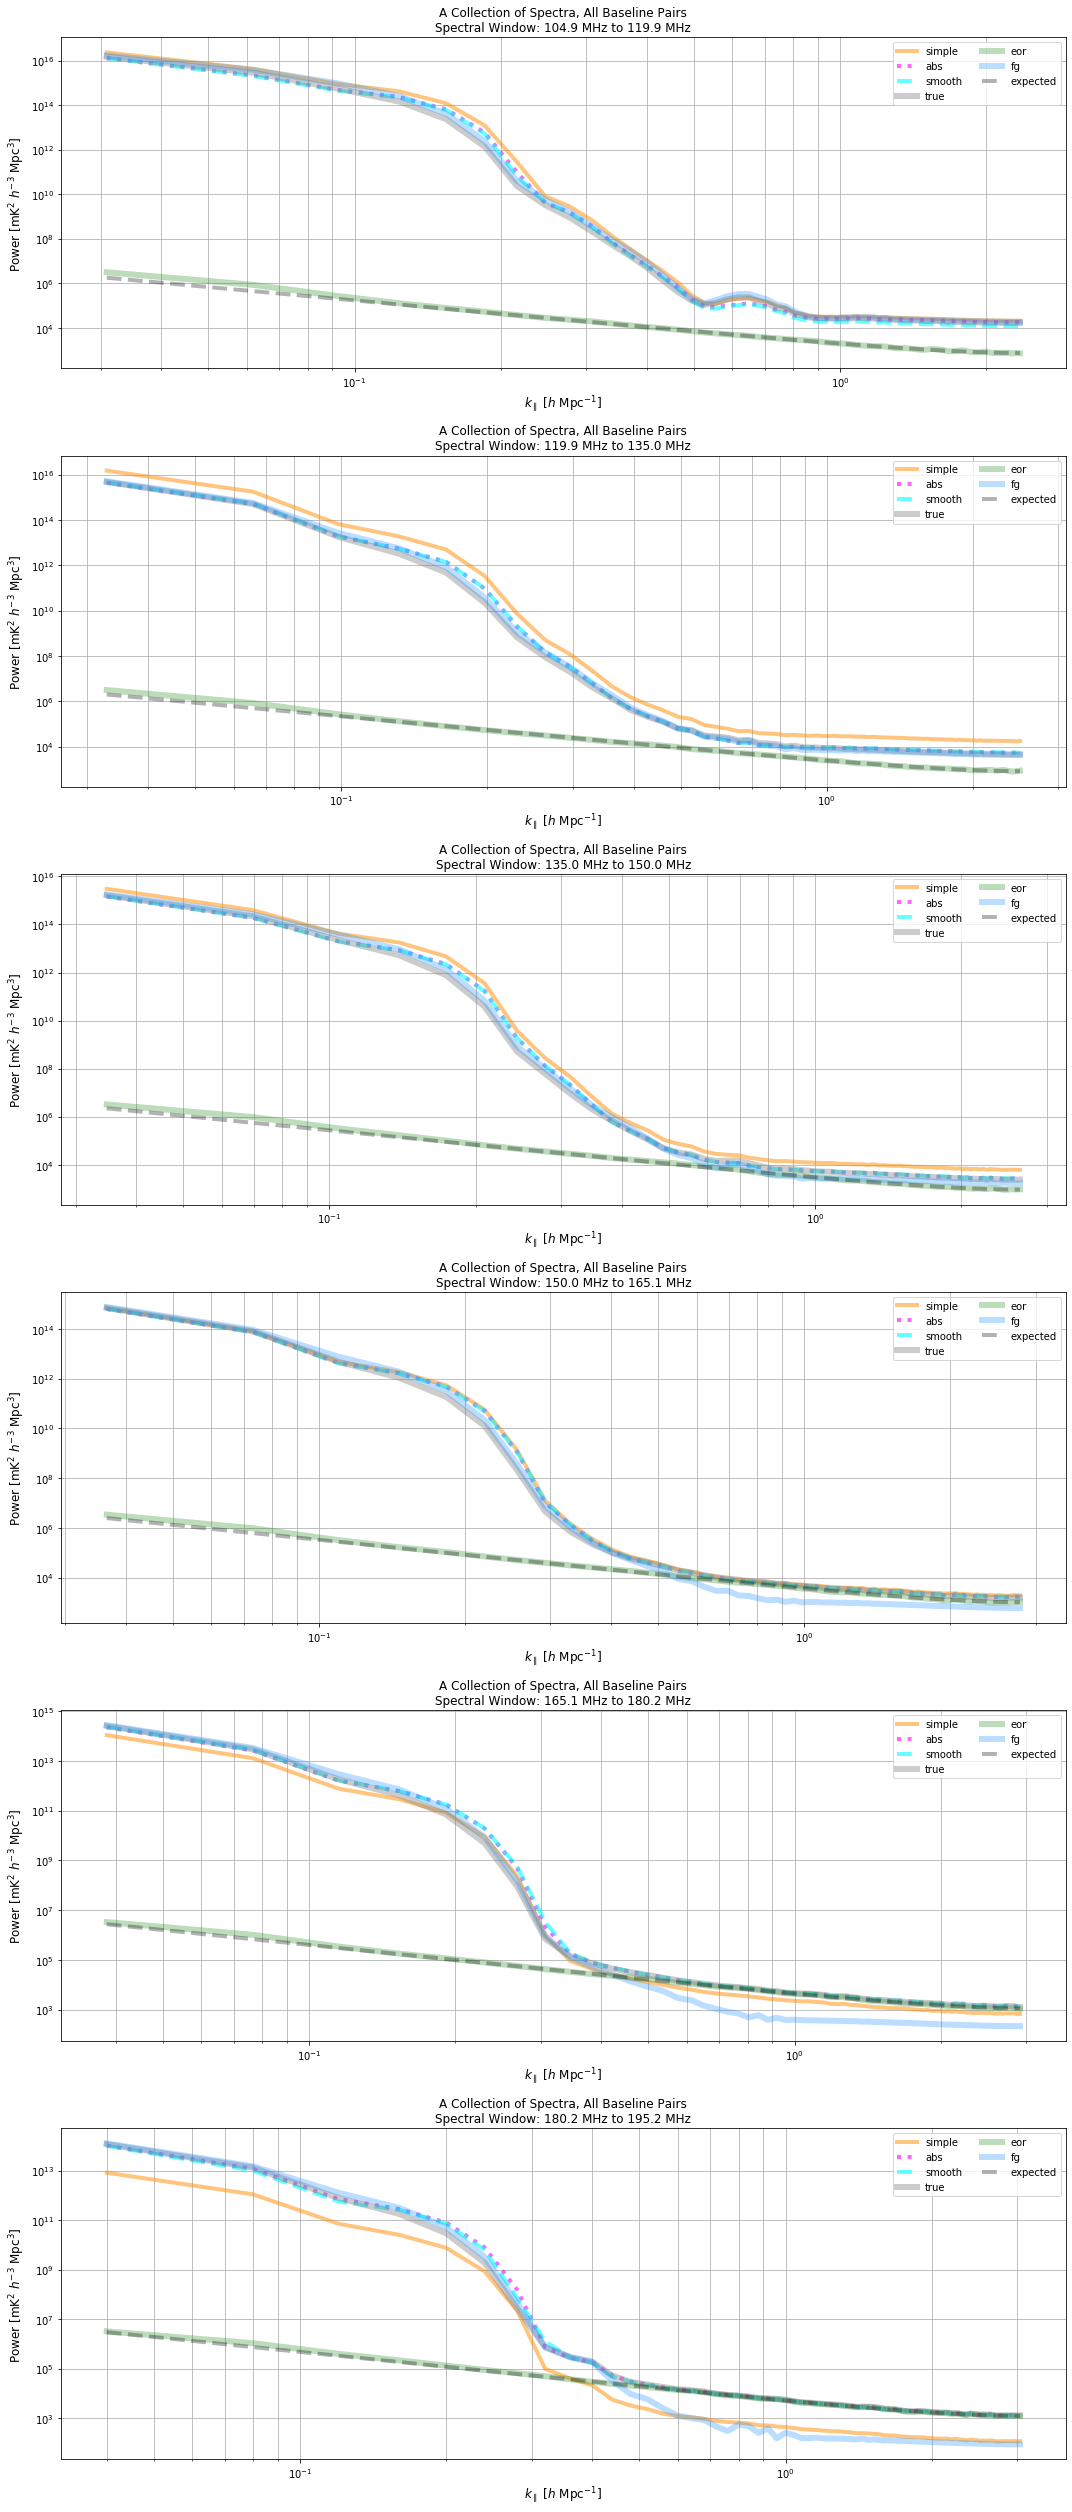

In [173]:
# for now, let's only plot the abscal, smoothed abscal, simple cal, and true power spectra
labels = ("simple", "abs", "smooth", "true", "eor", "fg")
spec_to_plot = {label : spectra[label] for label in labels}
colors = ("darkorange", "magenta", "cyan", "gray", "forestgreen", "dodgerblue")
alphas = (0.5, 0.6, 0.6, 0.4, 0.3, 0.3)
linestyles = ('-', ':', '--', '-', '-', '-')
lws = (4, 4, 4, 6, 6, 6)

# create a figure and axes objects
fig = plt.figure(figsize=(15,35))
axes = fig.subplots(6)

# setup stuff
for j in range(6):
    ax = axes[j]
    #ax.set_xlim(0.4, k_paras[j].max())
    #ax.set_ylim(10**2.75, 10**5.5)
    ax.grid(b=True, which="major", axis="y")
    ax.grid(b=True, which="both", axis="x")
    fmin, fmax = spw_edges[j]
    ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                  "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                  fontsize=12)
    ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
    #ax.set_xlabel("Delay [ns]", fontsize=12)
    ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
    
# plot all the ("measured") things    
for spec_dict, label, color, alpha, ls, lw in zip(spec_to_plot.values(), labels, colors, alphas, linestyles, lws):
    for spw, kparas in enumerate(k_paras):
        ax = axes[spw]
        spec_by_spw = spec_dict[spw]
        bl_avg = []
        for blp, spec in spec_by_spw.items():
            #ax.loglog(kparas, np.abs(spec.mean(axis=0)), marker='o', ms=2, color=color, alpha=0.3, lw=0)
            #ax.semilogy(dlys[spw], np.abs(spec.mean(axis=0)), marker='o', ms=2, color=color, alpha=0.3, lw=0)
            bl_avg.append(spec.mean(axis=0))
        bl_avg = np.array(bl_avg).mean(axis=0)
        ax.loglog(kparas, np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        #ax.semilogy(dlys[spw], np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        
# now plot the expected power spectra
for spw, kparas in enumerate(k_paras):
    ax = axes[spw]
    ax.loglog(kparas, aliased_spectra[spw], color='k', lw=4, ls='--', alpha=0.3, label="expected")
    ax.legend(ncol=2)
plt.tight_layout()
plt.show()
save_path = os.path.join(plot_path, "full_day_with_aliased_expectation_all_kparas.pdf")
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 11 |** Power spectra for the six spectral windows used in this analysis. Only auto-baseline pairs were used for power spectrum estimation. Each line notes the power spectrum estimate, incoherently averaged in time over the full eight hours of simulated data used and averaged over all baseline pairs. Note that the extent of foreground leakage appears to depend on choice of spectral window&mdash;we only see EoR dominate the signal at some $k$-modes in the last two spectral windows.

Note that the power spectrum estimates for the absolutely calibrated visibilities and the smoothed versions thereof tend to deviate toward the band edges (the first and last spectral windows), but are nearly identical for the middle spectral windows. A curious feature worth noting is that the power spectrum estimation for a given $k_\parallel$ mode is different between spectral windows; it is suspected that this is a consequence of the choice of windowing function and the relative amplitude of the foreground power and EoR power.

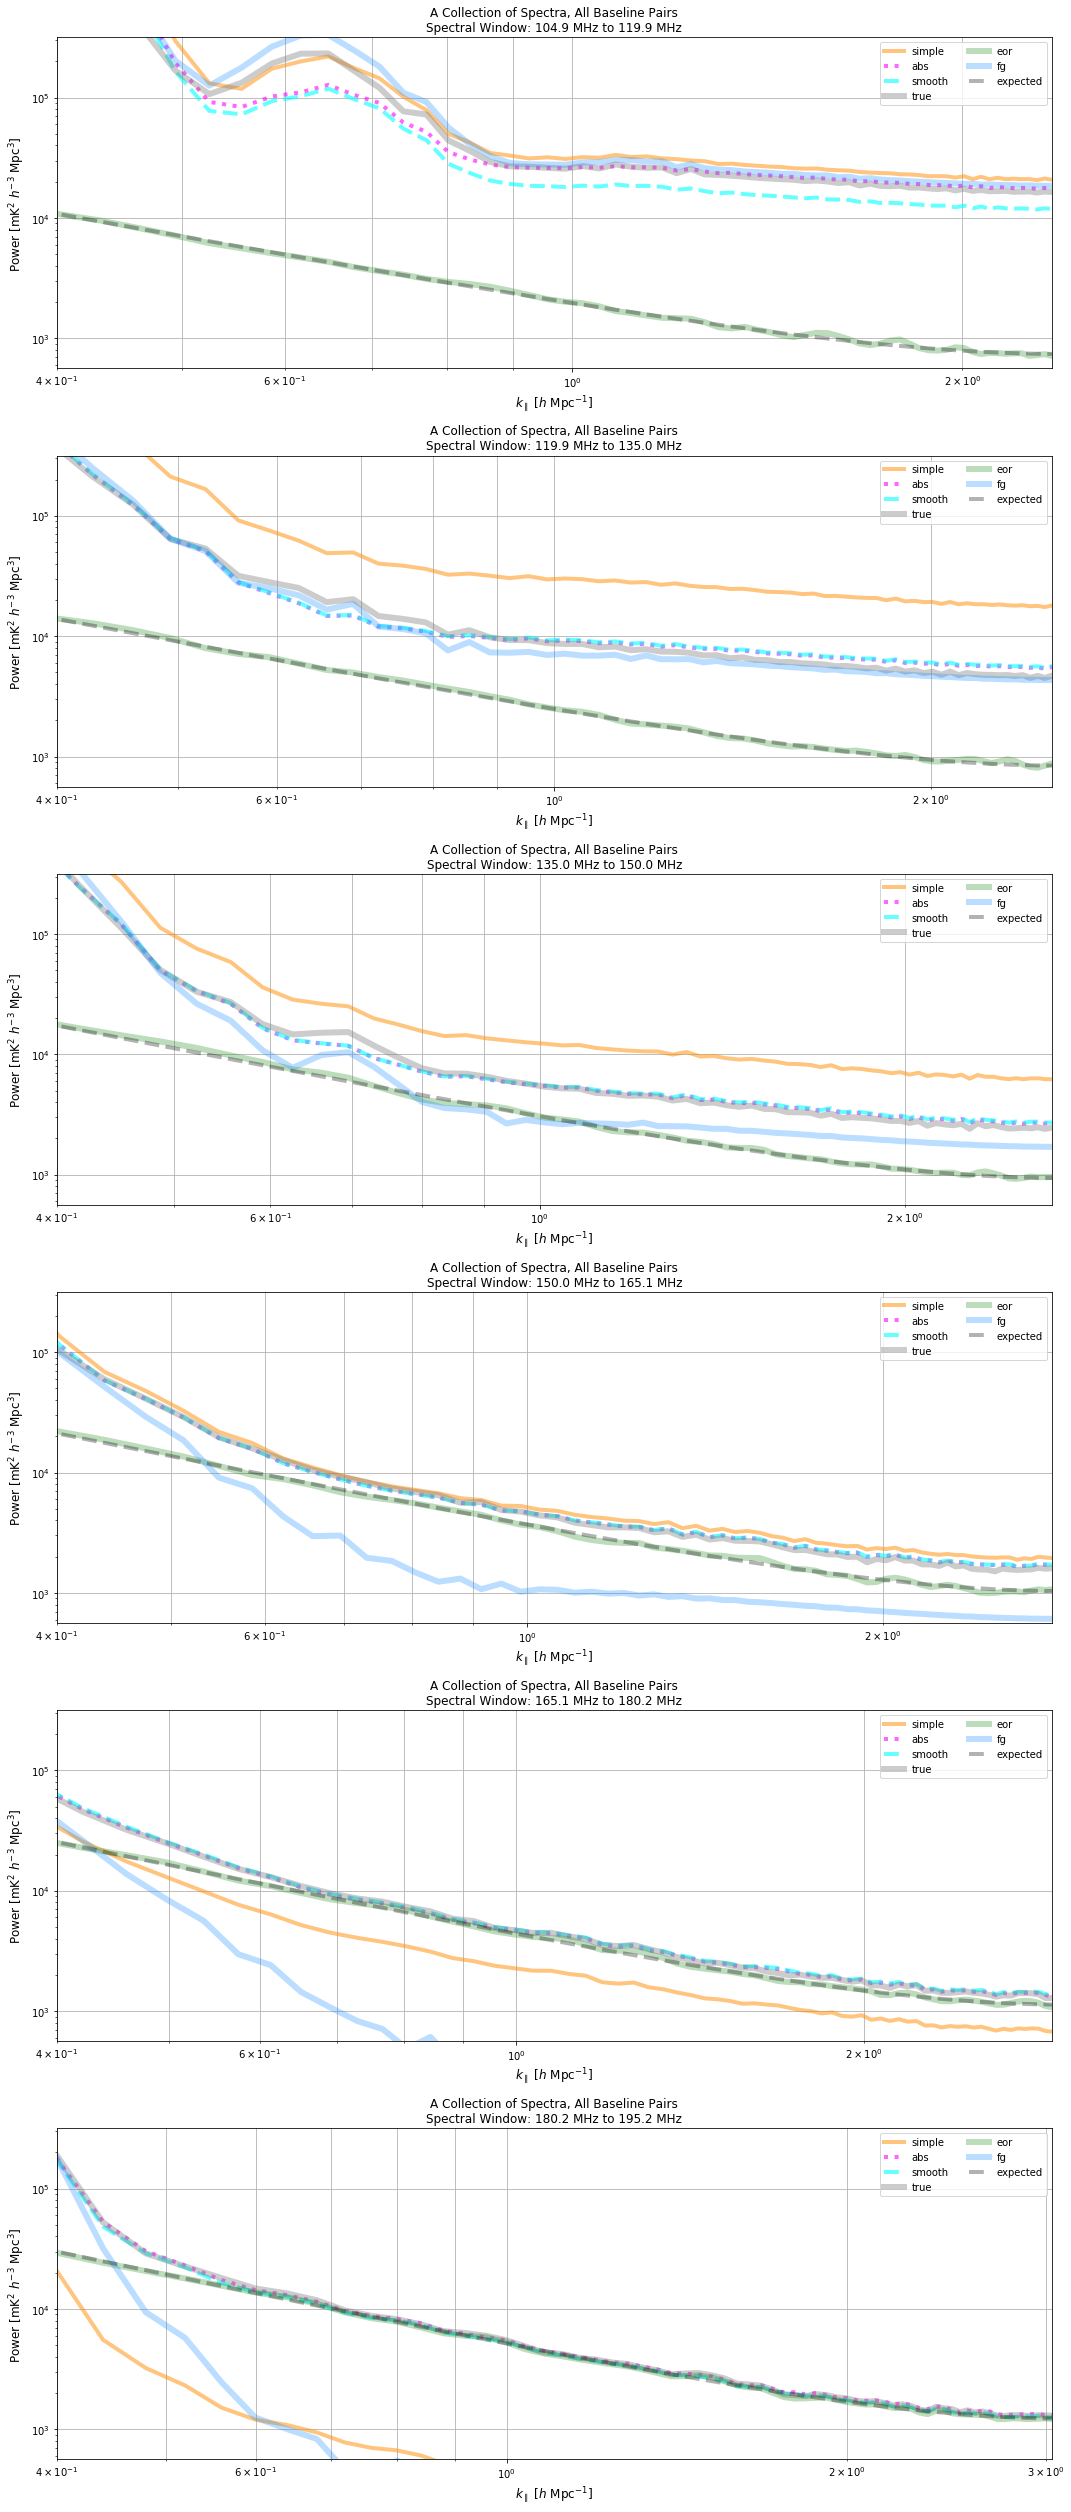

In [174]:
# create a figure and axes objects
fig = plt.figure(figsize=(15,35))
axes = fig.subplots(6)

# setup stuff
for j in range(6):
    ax = axes[j]
    ax.set_xlim(0.4, k_paras[j].max())
    ax.set_ylim(10**2.75, 10**5.5)
    ax.grid(b=True, which="major", axis="y")
    ax.grid(b=True, which="both", axis="x")
    fmin, fmax = spw_edges[j]
    ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                  "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                  fontsize=12)
    ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
    #ax.set_xlabel("Delay [ns]", fontsize=12)
    ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
    
# plot all the ("measured") things    
for spec_dict, label, color, alpha, ls, lw in zip(spec_to_plot.values(), labels, colors, alphas, linestyles, lws):
    for spw, kparas in enumerate(k_paras):
        ax = axes[spw]
        spec_by_spw = spec_dict[spw]
        bl_avg = []
        for blp, spec in spec_by_spw.items():
            #ax.loglog(kparas, np.abs(spec.mean(axis=0)), marker='o', ms=2, color=color, alpha=0.3, lw=0)
            #ax.semilogy(dlys[spw], np.abs(spec.mean(axis=0)), marker='o', ms=2, color=color, alpha=0.3, lw=0)
            bl_avg.append(spec.mean(axis=0))
        bl_avg = np.array(bl_avg).mean(axis=0)
        ax.loglog(kparas, np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        #ax.semilogy(dlys[spw], np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        
# now plot the expected power spectra
for spw, kparas in enumerate(k_paras):
    ax = axes[spw]
    ax.loglog(kparas, aliased_spectra[spw], color='k', lw=4, ls='--', alpha=0.3, label="expected")
    ax.legend(ncol=2)
plt.tight_layout()
plt.show()
save_path = os.path.join(plot_path, "full_day_with_aliased_expectation.pdf")
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 12 |** Same plot as above, but with the viewing window restricted to $k_\parallel$ values greater than 0.4 $h$ Mpc$^{-1}$.

## Frequency-Dependent EoR Amplitude

In the previous section, we found issues regarding the extraction of the expected EoR signal, likely due to issues regarding windowing and the difference in dynamic range of EoR and foregrounds. In this section, we perform the same analysis as in the previous section, but with an amplified, frequency-dependent EoR signal.

In [175]:
simple_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor*simple*.psc")))
abs_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor*.abs_vis.psc")))
smooth_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor*smooth*.psc")))
uncal_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor*uncal.psc")))
omni_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor*omni*.psc")))
true_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor.true.psc")))
eor_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.freq_dep_eor.psc")))
fg_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.fg_only.psc")))

In [176]:
globs = (simple_spec_glob, abs_spec_glob, smooth_spec_glob, uncal_spec_glob, 
         omni_spec_glob, true_spec_glob, eor_spec_glob, fg_spec_glob)

In [177]:
for spec_glob in globs:
    print(len(spec_glob))

0
0
0
0
0
0
269
100


In [178]:
%%time
# incoherently average all the spectra
# each spw has 154 channels, but we'll be folding the spectra

# initialize some dictionaries
simple_cal_spectra = {spw: {} for spw in range(6)}
abs_cal_spectra = {spw: {} for spw in range(6)}
smooth_abs_cal_spectra = {spw: {} for spw in range(6)}
omni_cal_spectra = {spw: {} for spw in range(6)}
uncal_spectra = {spw: {} for spw in range(6)}
true_spectra = {spw: {} for spw in range(6)}
eor_spectra = {spw: {} for spw in range(6)}
fg_spectra = {spw: {} for spw in range(6)}

# some stuff for making things easy
spectra = {"simple" : simple_cal_spectra,
           "abs" : abs_cal_spectra,
           "smooth" : smooth_abs_cal_spectra, 
           "uncal" : uncal_spectra,
           "omni" : omni_cal_spectra,
           "true" : true_spectra,
           "eor" : eor_spectra,
           "fg" : fg_spectra}

labels = tuple(spectra.keys())
assert len(labels) == len(globs)

#skip_data = ("uncal", "omni")
skip_data = (key for key in spectra.keys() if key != "eor")

for label, spec_glob in zip(labels, globs):
    if label in skip_data:
        continue
    spec_by_spw = spectra[label]
    for spec_file in spec_glob:
        psc = hera_pspec.container.PSpecContainer(spec_file, keep_open=False)
        uvp = psc.get_pspec(psc.groups()[0])[0]
        uvp.fold_spectra()
        for key in uvp.get_all_keys():
            spw = key[0]
            blp = key[1]
            try:
                spec_by_spw[spw][blp].append(uvp.get_data(key))
            except KeyError:
                spec_by_spw[spw][blp] = [uvp.get_data(key),]
        
del psc, uvp

CPU times: user 4min 46s, sys: 1min 32s, total: 6min 18s
Wall time: 10min 33s


In [179]:
# the spectra dictionaries should have 6 spws, and each spw should have Nblp dictionaries
# each dictionary spectra[spec_file][spw][blp] should have a list with length Nfiles
# each entry in the list should have shape (10, 76)
for label, spec_dict in spectra.items():
    if label in skip_data:
        continue
    for spw in spec_dict.keys():
        for blp in spec_dict[spw].keys():
            for spec in spec_dict[spw][blp]:
                assert spec.shape == (10,76)
                
# now let's re-shape from (Nfiles, Ntimes, Ndlys) to (Nfiles * Ntimes, Ndlys)
for label, spec_dict in spectra.items():
    if label in skip_data:
        continue
    for spec_by_spw in spec_dict.values():
        for blp, spec in spec_by_spw.items():
            spec = np.array(spec)
            new_shape = (spec.shape[0] * spec.shape[1], spec.shape[2])
            spec_by_spw[blp] = spec.reshape(new_shape)
            
# in the end we have an array of shape (Nspw, Nblps, Nfiles * Ntimes, Ndlys)

In [180]:
# get the spectral window edges, k_parallel values, and delays
psc = hera_pspec.container.PSpecContainer(eor_spec_glob[0], keep_open=False)
uvp = psc.get_pspec(psc.groups()[0])[0]
uvp.fold_spectra()
spw_edges = [(spw[0], spw[1]) for spw in uvp.get_spw_ranges()]
k_paras = [uvp.get_kparas(j) for j in range(6)]
#k_paras = [uvp.get_kparas(j, little_h=False) for j in range(6)]
dlys = [uvp.get_dlys(j) for j in range(6)]

# now get the expected power spectrum for each spectral window
aliased_spectra = {}
for j, kparas in enumerate(k_paras):
    # get the frequencies in the spectral window
    spw = uvp.freq_array[j*154 : (j+1)*154] # 154 channels per spectral window
    
    # get redshift at center of spectral window
    z = cosmo.f2z(np.mean(spw))
    
    # get co-moving distances sampled along LoS
    sampled_distances = np.array([cosmo.DC(z) for z in cosmo.f2z(spw)])
    
    # convert to approximate sampling frequency
    ks_est = np.pi/np.mean(np.abs(np.diff(sampled_distances)))
    
    # calculate aliased power spectrum
    aliased_spectra[j] = aliased_power_spectrum(kparas, ks_est, z=z, cosmo=cosmo, freq_dep=True)
    
del psc, uvp

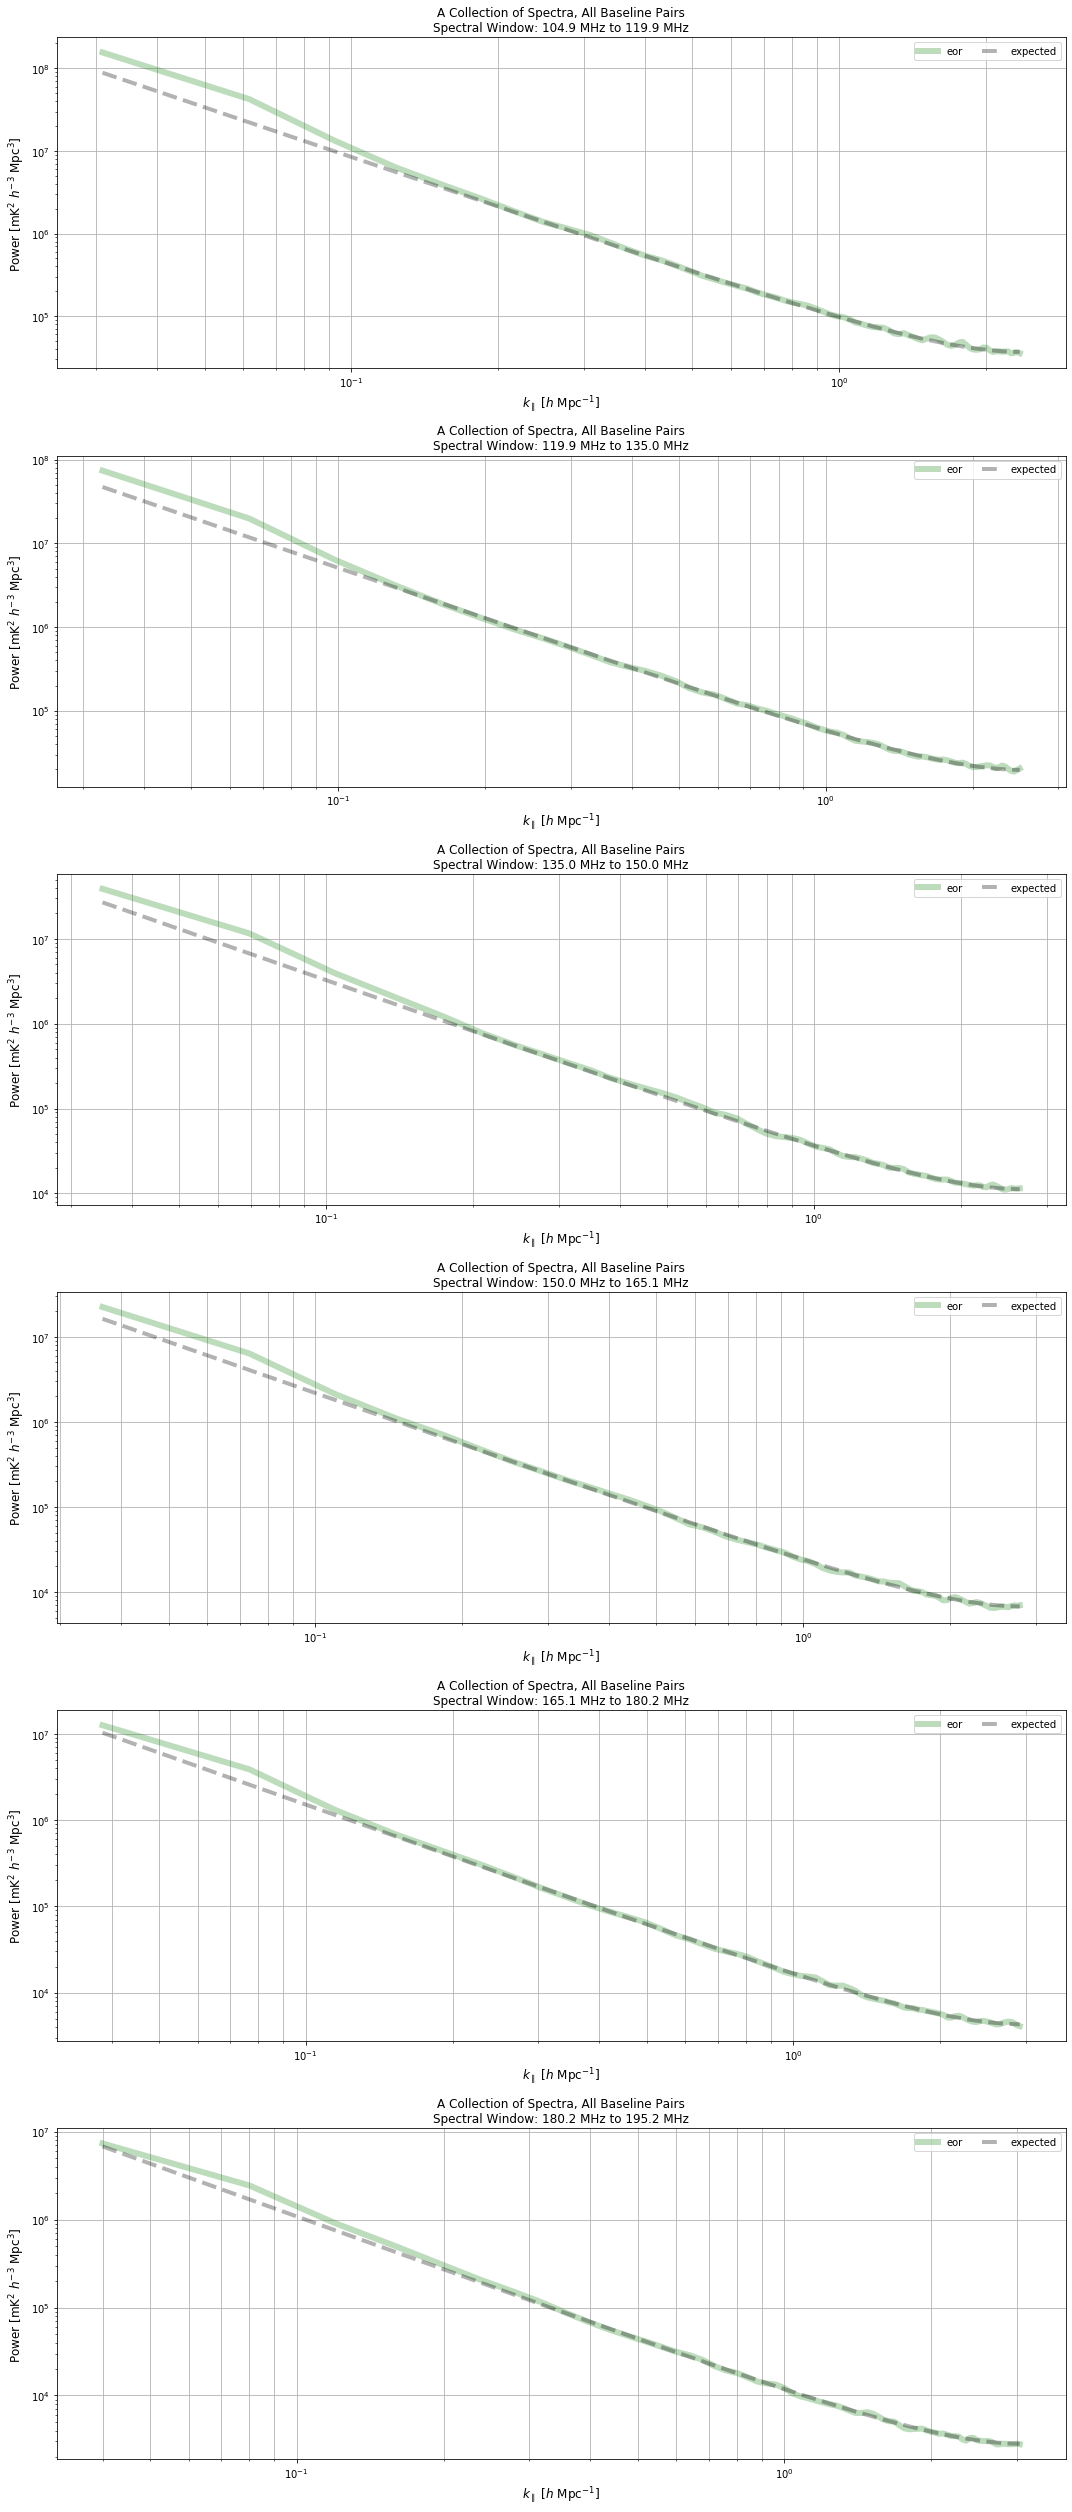

In [181]:
# for now, let's only plot the abscal, smoothed abscal, simple cal, and true power spectra
#labels = ("simple", "abs", "smooth", "true", "eor", "fg")
labels = ("eor", )
spec_to_plot = {label : spectra[label] for label in labels}
colors = ("forestgreen", )
alphas = (0.3, )
linestyles = ('-', )
lws = (6, )
#colors = ("darkorange", "magenta", "cyan", "gray", "forestgreen", "dodgerblue")
#alphas = (0.5, 0.6, 0.6, 0.4, 0.3, 0.3)
#linestyles = ('-', ':', '--', '-', '-', '-')
#lws = (4, 4, 4, 6, 6, 6)

# create a figure and axes objects
fig = plt.figure(figsize=(15,35))
axes = fig.subplots(6)

# setup stuff
for j in range(6):
    ax = axes[j]
    #ax.set_xlim(0.4, k_paras[j].max())
    #ax.set_ylim(10**2.75, 10**5.5)
    ax.grid(b=True, which="major", axis="y")
    ax.grid(b=True, which="both", axis="x")
    fmin, fmax = spw_edges[j]
    ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                  "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                  fontsize=12)
    ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
    #ax.set_xlabel("Delay [ns]", fontsize=12)
    ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
    
# plot all the ("measured") things    
for spec_dict, label, color, alpha, ls, lw in zip(spec_to_plot.values(), labels, colors, alphas, linestyles, lws):
    for spw, kparas in enumerate(k_paras):
        ax = axes[spw]
        spec_by_spw = spec_dict[spw]
        bl_avg = []
        for blp, spec in spec_by_spw.items():
            #ax.loglog(kparas, np.abs(spec.mean(axis=0)), marker='o', ms=2, color=color, alpha=0.3, lw=0)
            #ax.semilogy(dlys[spw], np.abs(spec.mean(axis=0)), marker='o', ms=2, color=color, alpha=0.3, lw=0)
            bl_avg.append(spec.mean(axis=0))
        bl_avg = np.array(bl_avg).mean(axis=0)
        ax.loglog(kparas, np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        #ax.semilogy(dlys[spw], np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        
# now plot the expected power spectra
for spw, kparas in enumerate(k_paras):
    ax = axes[spw]
    ax.loglog(kparas, aliased_spectra[spw], color='k', lw=4, ls='--', alpha=0.3, label="expected")
    ax.legend(ncol=2)
plt.tight_layout()
plt.show()
save_path = os.path.join(plot_path, "full_day_with_aliased_expectation_all_kparas_freq_dep_eor.pdf")
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 13 |** Something

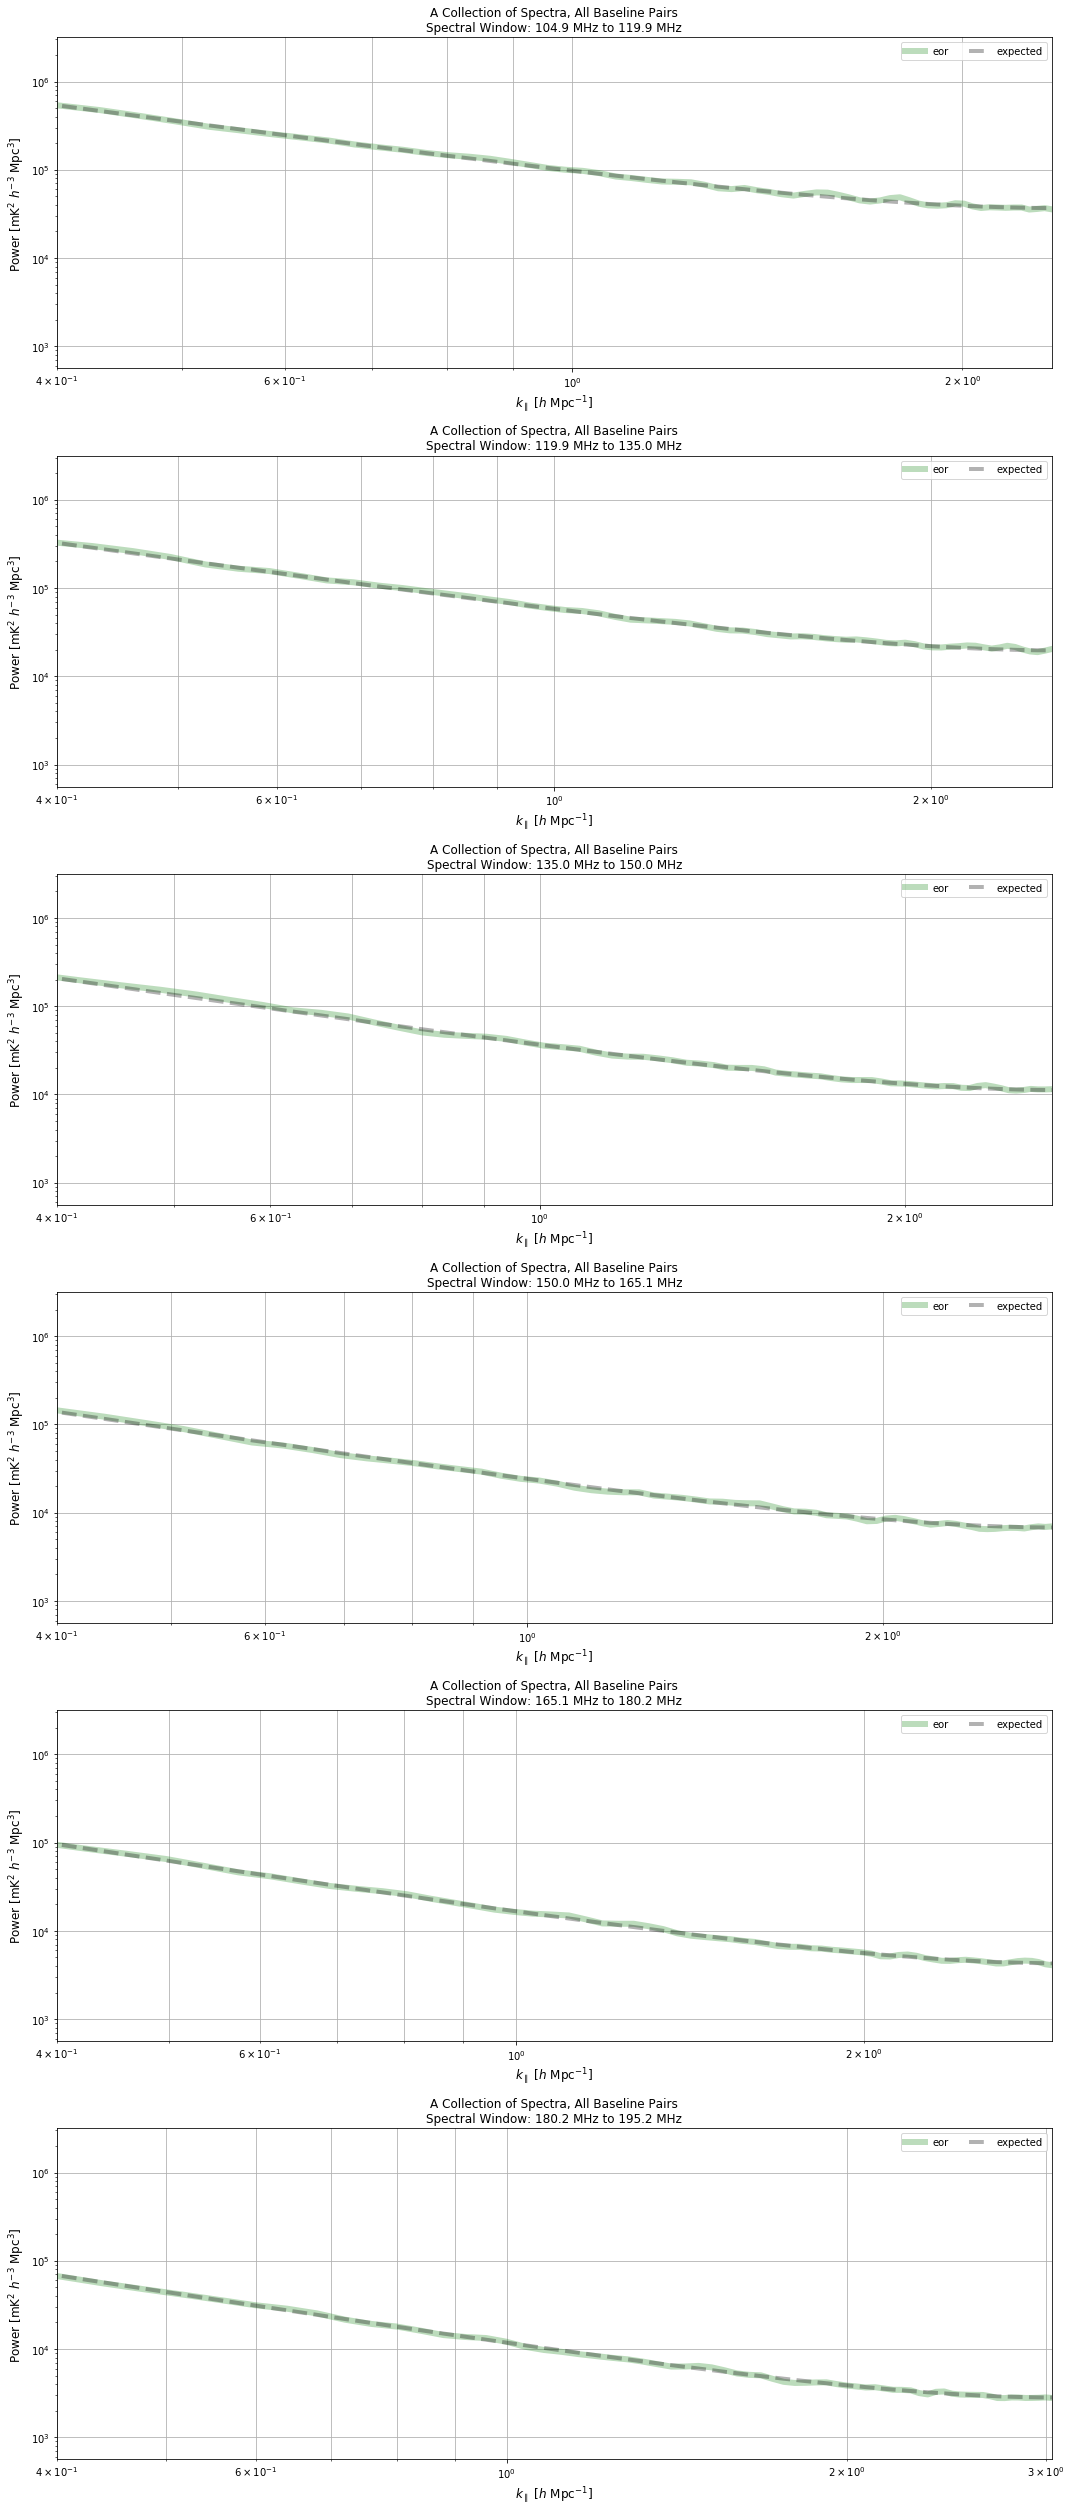

In [182]:
# create a figure and axes objects
fig = plt.figure(figsize=(15,35))
axes = fig.subplots(6)

# setup stuff
for j in range(6):
    ax = axes[j]
    ax.set_xlim(0.4, k_paras[j].max())
    ax.set_ylim(10**2.75, 10**6.5)
    ax.grid(b=True, which="major", axis="y")
    ax.grid(b=True, which="both", axis="x")
    fmin, fmax = spw_edges[j]
    ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                  "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                  fontsize=12)
    ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
    #ax.set_xlabel("Delay [ns]", fontsize=12)
    ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
    
# plot all the ("measured") things    
for spec_dict, label, color, alpha, ls, lw in zip(spec_to_plot.values(), labels, colors, alphas, linestyles, lws):
    for spw, kparas in enumerate(k_paras):
        ax = axes[spw]
        spec_by_spw = spec_dict[spw]
        bl_avg = []
        for blp, spec in spec_by_spw.items():
            #ax.loglog(kparas, np.abs(spec.mean(axis=0)), marker='o', ms=2, color=color, alpha=0.3, lw=0)
            #ax.semilogy(dlys[spw], np.abs(spec.mean(axis=0)), marker='o', ms=2, color=color, alpha=0.3, lw=0)
            bl_avg.append(spec.mean(axis=0))
        bl_avg = np.array(bl_avg).mean(axis=0)
        ax.loglog(kparas, np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        #ax.semilogy(dlys[spw], np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        
# now plot the expected power spectra
for spw, kparas in enumerate(k_paras):
    ax = axes[spw]
    ax.loglog(kparas, aliased_spectra[spw], color='k', lw=4, ls='--', alpha=0.3, label="expected")
    ax.legend(ncol=2)
plt.tight_layout()
plt.show()
save_path = os.path.join(plot_path, "full_day_with_aliased_expectation_freq_dep_eor.pdf")
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 14 |** Something